In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# representation of model layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import joblib
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB


In [ ]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import cudf  # Dùng cuDF để xử lý dữ liệu nhanh hơn trên GPU
import numpy as np
from sklearn.utils import resample

# Định nghĩa thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Danh sách 34 nhãn gốc từ CICIoT2023
labels = [
    'DDoS-ICMP_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood', 'DDoS-PSHACK_Flood',
    'DDoS-SYN_Flood', 'DDoS-RSTFINFlood', 'DDoS-SynonymousIP_Flood', 'DDoS-ICMP_Fragmentation',
    'DDoS-UDP_Fragmentation', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-SlowLoris',
    'DoS-UDP_Flood', 'DoS-TCP_Flood', 'DoS-SYN_Flood', 'DoS-HTTP_Flood',
    'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan', 'Recon-PingSweep',
    'VulnerabilityScan', 'MITM-ArpSpoofing', 'DNS_Spoofing', 'DictionaryBruteForce',
    'BrowserHijacking', 'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection',
    'Backdoor_Malware', 'Mirai-greeth_flood', 'Mirai-udpplain', 'Mirai-greip_flood',
    'BenignTraffic'
]

# Khởi tạo dictionary để theo dõi số dòng của từng nhãn
label_counts = {label: 0 for label in labels}

# Giới hạn tối đa và tối thiểu 200,000 dòng cho mỗi nhãn
MAX_ROWS_PER_LABEL = 100_000
MIN_ROWS_PER_LABEL = 100_000

# Hàm đọc file và lọc dữ liệu
def read_file(filename, index):
    try:
        # Đọc file CSV bằng cuDF
        df = cudf.read_csv(filename)
        
        # Kiểm tra cột 'label'
        if 'label' not in df.columns:
            print(f"❌ File {filename}: Không tìm thấy cột 'label'!")
            return None
        
        # Lọc dữ liệu dựa trên giới hạn 200K cho mỗi nhãn
        valid_rows = []
        unique_labels = df['label'].unique().to_pandas().tolist()
        for label in unique_labels:
            if label not in labels:
                continue  # Bỏ qua nhãn không thuộc danh sách 34 nhãn
            
            current_count = label_counts.get(label, 0)
            remaining_quota = MAX_ROWS_PER_LABEL - current_count
            
            if remaining_quota <= 0:
                print(f"⚠ Nhãn {label} đã đủ {MAX_ROWS_PER_LABEL:,} dòng, không đọc thêm!")
                continue
            
            # Lấy các dòng thuộc nhãn này
            label_df = df[df['label'] == label]
            rows_to_take = min(len(label_df), remaining_quota)
            
            if rows_to_take > 0:
                valid_rows.append(label_df[:rows_to_take])
                label_counts[label] = current_count + rows_to_take
                print(f"📌 Nhãn {label}: Thêm {rows_to_take:,} dòng, tổng cộng {label_counts[label]:,} dòng")
        
        # Gộp các dòng hợp lệ
        if valid_rows:
            df_filtered = cudf.concat(valid_rows, ignore_index=True)
            print(f"📌 File {index}: Giữ {df_filtered.shape[0]:,} dòng sau khi lọc giới hạn")
            return df_filtered
        else:
            print(f"⚠ File {index}: Không có dữ liệu nào được giữ lại!")
            return None
    except Exception as e:
        print(f"❌ Lỗi khi đọc file {filename}: {e}")
        return None

# Đọc dữ liệu từ thư mục
data_dir = "/kaggle/input/cic-iot-2023/"
file_list = glob.glob(f"{data_dir}*.csv")[:134]  # Lấy tối đa 134 file

# Đọc tuần tự từng file
dfs = []
for idx, fname in enumerate(file_list):
    df = read_file(fname, idx)
    if df is not None:
        dfs.append(df)

# Nối dữ liệu và xử lý cân bằng
if dfs:
    df_full = cudf.concat(dfs, ignore_index=True)
    print(f"✅ Dữ liệu đã được nối! Kích thước: {df_full.shape}")
    print(f"📋 Nhãn duy nhất: {df_full['label'].unique().to_pandas().tolist()}")
    
    # Chuyển sang pandas để xử lý oversampling
    df_pandas = df_full.to_pandas()
    
    # Kiểm tra phân bố nhãn trước khi cân bằng
    print("\n📋 Phân bố nhãn trước khi cân bằng:")
    label_distribution = df_pandas["label"].value_counts()
    print(label_distribution)
    
    # Vẽ biểu đồ phân bố nhãn trước khi cân bằng
    fig, ax = plt.subplots(figsize=(16, 8))
    bars = ax.bar(label_distribution.index, label_distribution.values, color='skyblue')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of 34 Labels (Before Oversampling)')
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution_before_oversampling_34labels.png')
    plt.show()
    
    # Chuẩn bị dữ liệu cho oversampling
    balanced_dfs = []
    unique_labels = df_pandas['label'].unique()
    
    # Áp dụng oversampling thủ công cho mỗi nhãn
    for label in unique_labels:
        if label not in labels:
            continue
        label_df = df_pandas[df_pandas['label'] == label]
        current_count = len(label_df)
        
        if current_count < MIN_ROWS_PER_LABEL:
            # Oversampling bằng resample
            oversampled_df = resample(
                label_df,
                replace=True,  # Cho phép sao chép mẫu
                n_samples=MIN_ROWS_PER_LABEL,  # Đạt 200K
                random_state=42
            )
            print(f"📌 Oversampling nhãn {label}: Từ {current_count:,} lên {MIN_ROWS_PER_LABEL:,} dòng")
            balanced_dfs.append(oversampled_df)
        else:
            print(f"📌 Nhãn {label}: Đã có {current_count:,} dòng, giữ nguyên")
            balanced_dfs.append(label_df)
    
    # Gộp dữ liệu đã cân bằng
    df_balanced = pd.concat(balanced_dfs, ignore_index=True)
    
    # Chuyển lại thành cuDF để đồng bộ
    df_full = cudf.from_pandas(df_balanced)
    
    # Kiểm tra phân bố nhãn sau khi cân bằng
    print("\n📋 Phân bố nhãn sau khi cân bằng bằng oversampling:")
    balanced_label_distribution = df_full["label"].value_counts().to_pandas()
    print(balanced_label_distribution)
    
    # Vẽ biểu đồ phân bố nhãn sau khi cân bằng
    fig, ax = plt.subplots(figsize=(16, 8))
    bars = ax.bar(balanced_label_distribution.index, balanced_label_distribution.values, color='skyblue')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of 34 Labels (After Oversampling)')
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution_after_oversampling_34labels.png')
    plt.show()
    
   
    
else:
    print("⚠ Không có file nào được đọc thành công hoặc tất cả dữ liệu rỗng!")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
import pickle
import os
import matplotlib.pyplot as plt

# Đường dẫn lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Giả định df_full là DataFrame từ cell đọc dữ liệu trước đó (cuDF)
# Chuyển từ cuDF sang Pandas
df_original = df_full.to_pandas()

# Kiểm tra dữ liệu đầu vào
if df_original.empty or 'label' not in df_original.columns:
    raise ValueError("❌ Dữ liệu đầu vào rỗng hoặc thiếu cột 'label'!")

# Xử lý giá trị thiếu cho cột số
numeric_columns = df_original.select_dtypes(include=[np.number]).columns
df_original[numeric_columns] = df_original[numeric_columns].fillna(df_original[numeric_columns].mean())

# Tách đặc trưng và nhãn
X = df_original.drop(columns=['label']).select_dtypes(include=[np.number])
y = df_original['label']

# Kiểm tra nhãn duy nhất
print("📋 Nhãn duy nhất trong dữ liệu:", y.unique().tolist())
if len(y.unique()) != 34:
    print(f"⚠️ Cảnh báo: Tìm thấy {len(y.unique())} nhãn, kỳ vọng 34 nhãn!")

# Lấy tất cả đặc trưng (loại bỏ cột 'label')
selected_features = list(X.columns)
print(f"📌 Số đặc trưng được chọn: {len(selected_features)}")
if len(selected_features) != 45:
    print(f"⚠️ Cảnh báo: Tìm thấy {len(selected_features)} đặc trưng, kỳ vọng 45 đặc trưng sau khi loại bỏ 'label'!")

# Kiểm tra xem các đặc trưng có tồn tại trong dữ liệu không
missing_features = [f for f in selected_features if f not in X.columns]
if missing_features:
    raise ValueError(f"❌ Các đặc trưng sau không tồn tại trong dữ liệu: {missing_features}")

# Lấy chỉ số của các đặc trưng
feature_indices = [list(X.columns).index(f) for f in selected_features]

# Áp dụng các đặc trưng (giữ nguyên toàn bộ 45 đặc trưng)
X = X[selected_features]

# Chia dữ liệu thành tập train, val, test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.1875, stratify=Y_temp, random_state=42)

# Mã hóa nhãn (34 nhãn gốc)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("📊 Ánh xạ nhãn (34 nhãn):", label_mapping)

# Kiểm tra phân bố nhãn
print("\n📊 Phân bố nhãn trong tập huấn luyện:")
print(pd.Series(Y_train_encoded).value_counts().rename(label_mapping))
print("\n📊 Phân bố nhãn trong tập validation:")
print(pd.Series(Y_val_encoded).value_counts().rename(label_mapping))
print("\n📊 Phân bố nhãn trong tập kiểm tra:")
print(pd.Series(Y_test_encoded).value_counts().rename(label_mapping))

# Xử lý NaN và outlier bằng KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu bằng RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Kiểm tra giá trị sau khi chọn đặc trưng
print("🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:")
print(pd.DataFrame(X_train_scaled, columns=selected_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_val_scaled:")
print(pd.DataFrame(X_val_scaled, columns=selected_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_test_scaled:")
print(pd.DataFrame(X_test_scaled, columns=selected_features).describe().loc[['min', 'max']])

# Lưu dữ liệu đã xử lý
np.save(f"{output_dir}/X_train_scaled_34labels.npy", X_train_scaled)
np.save(f"{output_dir}/Y_train_encoded_34labels.npy", Y_train_encoded)
np.save(f"{output_dir}/X_val_scaled_34labels.npy", X_val_scaled)
np.save(f"{output_dir}/Y_val_encoded_34labels.npy", Y_val_encoded)
np.save(f"{output_dir}/X_test_scaled_34labels.npy", X_test_scaled)
np.save(f"{output_dir}/Y_test_encoded_34labels.npy", Y_test_encoded)

# Lưu các đối tượng xử lý
with open(f"{output_dir}/label_encoder_34labels.pkl", 'wb') as f:
    pickle.dump(label_encoder, f)
with open(f"{output_dir}/scaler_34labels.pkl", 'wb') as f:
    pickle.dump(scaler, f)
with open(f"{output_dir}/imputer_34labels.pkl", 'wb') as f:
    pickle.dump(imputer, f)
with open(f"{output_dir}/selected_features_34labels.pkl", 'wb') as f:
    pickle.dump(selected_features, f)

# In thông tin chi tiết
print(f"✅ Dữ liệu đã xử lý và lưu trong '{output_dir}'!")
print(f"📌 Số đặc trưng được chọn: {len(selected_features)}")
print(f"📋 Các đặc trưng được chọn: {selected_features}")

# Vẽ biểu đồ danh sách đặc trưng được chọn
plt.figure(figsize=(15, 6))  # Tăng kích thước để hiển thị 45 đặc trưng
plt.bar(selected_features, [1] * len(selected_features), color='skyblue')
plt.title('Selected Features for Classification (45 Features, 34 Labels)', fontsize=12, fontweight='bold')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Selected', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.savefig(f"{output_dir}/selected_features_34labels.png")
plt.show()

In [ ]:
import numpy as np
import joblib
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Tải dữ liệu đã xử lý
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_34labels.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_34labels.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_34labels.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_34labels.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_34labels.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_34labels.npy")

# Kiểm tra shape dữ liệu
print(f"📌 Shape dữ liệu: train {X_train_scaled.shape}, val {X_val_scaled.shape}, test {X_test_scaled.shape}")
if X_train_scaled.shape[1] != 46:
    raise ValueError(f"❌ Số đặc trưng không phải 46, tìm thấy {X_train_scaled.shape[1]} đặc trưng!")
if len(np.unique(Y_train_encoded)) != 34:
    raise ValueError(f"❌ Số nhãn không phải 34, tìm thấy {len(np.unique(Y_train_encoded))} nhãn!")

# Chia 46 đặc trưng thành 5 nhóm (4 nhóm 9 đặc trưng, 1 nhóm 10 đặc trưng)
n_groups = 5
base_group_size = 46 // n_groups  # 9 đặc trưng mỗi nhóm
remainder = 46 % n_groups  # 1 đặc trưng dư
group_sizes = [base_group_size + 1 if i < remainder else base_group_size for i in range(n_groups)]
group_boundaries = np.cumsum([0] + group_sizes)
X_train_grouped = []
X_val_grouped = []
X_test_grouped = []

print("🔄 Tạo đặc trưng xác suất nhóm bằng XGBoost...")
for i in range(n_groups):
    start_idx = group_boundaries[i]
    end_idx = group_boundaries[i + 1]
    X_train_group = X_train_scaled[:, start_idx:end_idx]  # Shape: [n_samples, 9 hoặc 10]
    X_val_group = X_val_scaled[:, start_idx:end_idx]
    X_test_group = X_test_scaled[:, start_idx:end_idx]

    # Kiểm tra shape của nhóm
    print(f"Nhóm {i+1}: Shape X_train_group: {X_train_group.shape}")

    # Huấn luyện XGBoost trên nhóm đặc trưng
    xgb = XGBClassifier(
        n_estimators=50,
        max_depth=8,
        min_child_weight=10,
        tree_method="hist",
        device="cuda",
        random_state=42,
        objective="multi:softprob",
        num_class=34
    )
    xgb.fit(X_train_group, Y_train_encoded)

    # Tạo xác suất dự đoán
    train_probs = xgb.predict_proba(X_train_group)  # Shape: [n_samples, 34]
    val_probs = xgb.predict_proba(X_val_group)
    test_probs = xgb.predict_proba(X_test_group)

    X_train_grouped.append(train_probs)
    X_val_grouped.append(val_probs)
    X_test_grouped.append(test_probs)

    # Lưu mô hình XGBoost
    joblib.dump(xgb, f"{output_dir}/xgb_group_{i}_34labels.joblib")
    print(f"✅ Đã xử lý nhóm {i+1}/{n_groups}")

# Gộp đặc trưng xác suất
X_train_grouped = np.concatenate(X_train_grouped, axis=1)  # Shape: [n_samples, 5*34 = 170]
X_val_grouped = np.concatenate(X_val_grouped, axis=1)
X_test_grouped = np.concatenate(X_test_grouped, axis=1)

# Kiểm tra shape sau khi gộp
print(f"📌 Shape X_train_grouped: {X_train_grouped.shape}")

# Kết hợp với top-k đặc trưng gốc
k = 10  # Chọn 10 đặc trưng quan trọng nhất
xgb_full = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    min_child_weight=10,
    tree_method="hist",
    device="cuda",
    random_state=42,
    objective="multi:softprob",
    num_class=34
)
xgb_full.fit(X_train_scaled, Y_train_encoded)
feature_importance = xgb_full.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1][:k]

# Kết hợp đặc trưng xác suất và đặc trưng gốc
X_train_combined = np.concatenate([X_train_grouped, X_train_scaled[:, sorted_idx]], axis=1)  # Shape: [n_samples, 170+10 = 180]
X_val_combined = np.concatenate([X_val_grouped, X_val_scaled[:, sorted_idx]], axis=1)
X_test_combined = np.concatenate([X_test_grouped, X_test_scaled[:, sorted_idx]], axis=1)

# Kiểm tra shape sau khi kết hợp
print(f"📌 Shape X_train_combined: {X_train_combined.shape}")

# Chuẩn hóa lại dữ liệu
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

# Lưu dữ liệu
np.save(f"{output_dir}/X_train_combined_34labels.npy", X_train_combined)
np.save(f"{output_dir}/X_val_combined_34labels.npy", X_val_combined)
np.save(f"{output_dir}/X_test_combined_34labels.npy", X_test_combined)
joblib.dump(scaler, f"{output_dir}/scaler_combined_34labels.joblib")

# In thông tin
print(f"✅ Đã tạo đặc trưng kết hợp!")
print(f"📌 Shape: train {X_train_combined.shape}, val {X_val_combined.shape}, test {X_test_combined.shape}")
print(f"📌 Số đặc trưng: {X_train_combined.shape[1]} (170 xác suất + 10 gốc)")
print(f"📌 Top-10 đặc trưng gốc (chỉ số): {sorted_idx}")

# **DCN-V2**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import shap
import os
import scipy.stats as stats
import scipy.special
import joblib
from tqdm import tqdm
from collections import Counter

# Định nghĩa các lớp cần thiết
class GhostBN1d(torch.nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = torch.nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class CrossLayer(torch.nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = torch.nn.Parameter(torch.randn(input_dim, input_dim) * 0.01)
        self.bias = torch.nn.Parameter(torch.zeros(input_dim))
        self.norm = torch.nn.LayerNorm(input_dim)
        torch.nn.init.xavier_normal_(self.weight, gain=0.1)
        torch.nn.init.zeros_(self.bias)

    def forward(self, x_0, x_l):
        x_l_w = torch.matmul(x_l, self.weight)
        x_l_w_b = x_l_w + self.bias
        x_0_dot = x_0 * x_l_w_b
        x_l_plus_1 = x_0_dot + x_l
        x_l_plus_1 = self.norm(x_l_plus_1)
        return x_l_plus_1

class DCNV2(torch.nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.cross_layers = torch.nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                torch.nn.Linear(prev_dim, deep_layer_dim),
                torch.nn.BatchNorm1d(deep_layer_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.1)
            ])
            prev_dim = deep_layer_dim
        self.deep = torch.nn.Sequential(*deep_layers)
        self.combine_fc = torch.nn.Linear(input_dim + deep_layer_dim, num_classes)
        torch.nn.init.xavier_normal_(self.combine_fc.weight, gain=0.1)
        torch.nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = torch.nn.Linear(input_dim, input_dim)
        torch.nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        x_0 = x
        x_cross = x
        for layer in self.cross_layers:
            x_cross = layer(x_0, x_cross)
        x_deep = self.deep(x)
        combined = torch.cat([x_cross, x_deep], dim=1)
        output = self.combine_fc(combined)
        return output

# Thư mục lưu trữ
results_dir = "/kaggle/input/ketqua34nhan/dcnv2-34nhan-cuoi/results"
output_dir = "processed_data"
Kq = "DCN-v2_34labels_170features_improved"
os.makedirs(Kq, exist_ok=True)
print(f"📁 Đã tạo thư mục lưu kết quả: {Kq}")

# Kiểm tra sự tồn tại của các tệp dữ liệu
data_files = [
    f"{output_dir}/X_test_combined_34labels.npy",
    f"{output_dir}/Y_test_encoded_34labels.npy",
    f"{results_dir}/feature_importance_34labels_170features_dcnv2.npy",
    f"{results_dir}/dcnv2_34labels_170features.pth"
]
for file_path in data_files:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Tệp không tồn tại: {file_path}")

# Tải dữ liệu
try:
    X_test_combined = np.load(f"{output_dir}/X_test_combined_34labels.npy")[:, :170]
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_34labels.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_34labels_170features_dcnv2.npy")
    tqdm.write("✅ Đã tải dữ liệu cần thiết cho DCN-V2 (34 nhãn, 170 đặc trưng)")
    tqdm.write(f"X_test_combined shape: {X_test_combined.shape}")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape
if X_test_combined.shape[1] != 170:
    raise ValueError(f"❌ Shape của X_test_combined không đúng: {X_test_combined.shape[1]}, kỳ vọng 170 đặc trưng")
if len(np.unique(Y_test_encoded)) != 34:
    raise ValueError(f"❌ Số nhãn không đúng: {len(np.unique(Y_test_encoded))}, kỳ vọng 34 nhãn")

# Kiểm tra shape của feature_importance
tqdm.write(f"📌 Shape của feature_importance: {feature_importance.shape}")
if len(feature_importance.shape) == 2 and feature_importance.shape[0] > 170:
    feature_importance = feature_importance.mean(axis=0)
    tqdm.write(f"📌 Đã điều chỉnh shape feature_importance thành: {feature_importance.shape}")
if feature_importance.shape != (170,):
    tqdm.write(f"⚠️ feature_importance không có shape (170,): {feature_importance.shape}. Bỏ qua tính độ tương quan.")
    feature_importance_valid = False
else:
    feature_importance_valid = True

# Chuẩn hóa dữ liệu
X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)

# Ánh xạ nhãn với danh sách nhãn thực tế
label_map = {
    0: 'Mirai-greeth_flood', 1: 'DDoS-TCP_Flood', 2: 'DDoS-RSTFINFlood', 3: 'DDoS-UDP_Flood',
    4: 'DDoS-ICMP_Flood', 5: 'DDoS-ACK_Fragmentation', 6: 'DDoS-SynonymousIP_Flood',
    7: 'DDoS-PSHACK_Flood', 8: 'Mirai-udpplain', 9: 'DDoS-SYN_Flood', 10: 'MITM-ArpSpoofing',
    11: 'BenignTraffic', 12: 'Mirai-greip_flood', 13: 'DoS-UDP_Flood', 14: 'DNS_Spoofing',
    15: 'DoS-TCP_Flood', 16: 'DoS-SYN_Flood', 17: 'DDoS-UDP_Fragmentation',
    18: 'DDoS-ICMP_Fragmentation', 19: 'Recon-OSScan', 20: 'Recon-HostDiscovery',
    21: 'Recon-PortScan', 22: 'DoS-HTTP_Flood', 23: 'VulnerabilityScan', 24: 'DDoS-HTTP_Flood',
    25: 'DDoS-SlowLoris', 26: 'DictionaryBruteForce', 27: 'CommandInjection', 28: 'SqlInjection',
    29: 'BrowserHijacking', 30: 'Backdoor_Malware', 31: 'Recon-PingSweep', 32: 'XSS',
    33: 'Uploading_Attack'
}
class_names = [label_map[i] for i in range(len(label_map))]
tqdm.write(f"📊 Đã ánh xạ 34 nhãn: {label_map}")

# 46 đặc trưng gốc
feature_labels_original = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate',
    'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
    'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP',
    'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance',
    'Variance', 'Weight'
]

# Tên đặc trưng cho 170 xác suất
feature_names = [f"Prob_group{i+1}_class{j}" for i in range(5) for j in range(34)]
tqdm.write(f"📋 Các đặc trưng (170 xác suất): {feature_names[:10]}... (hiển thị 10 đặc trưng đầu)")

# Ánh xạ 46 đặc trưng gốc đến 5 nhóm XGBoost
group_sizes = [10, 9, 9, 9, 9]
group_boundaries = np.cumsum([0] + group_sizes)
feature_to_group = {}
for group_idx in range(5):
    start_idx = group_boundaries[group_idx]
    end_idx = group_boundaries[group_idx + 1]
    for i in range(start_idx, end_idx):
        feature_to_group[feature_labels_original[i]] = group_idx + 1

# Index của xác suất cho mỗi nhóm
group_indices = {
    1: range(0, 34),
    2: range(34, 68),
    3: range(68, 102),
    4: range(102, 136),
    5: range(136, 170)
}

# Thiết lập thiết bị và tải mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = DCNV2(input_dim=170, num_classes=34, deep_layer_dim=128).to(device)
    model.load_state_dict(torch.load(f"{results_dir}/dcnv2_34labels_170features.pth", map_location=device, weights_only=True))
    model.eval()
    tqdm.write("✅ Đã tải mô hình DCN-V2 thành công")

    # Hàm dự đoán cho KernelExplainer với chuẩn hóa logits
    def predict_fn(inputs):
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs_tensor)
            outputs = outputs / torch.max(torch.abs(outputs))  # Chuẩn hóa logits
        return outputs.cpu().numpy()

    # Chuẩn bị dữ liệu cho SHAP
    X_test_np = X_test_combined[:50]
    Y_test_np = Y_test_encoded[:50]
    background = X_test_np[:100]

    # Kiểm tra phân bố nhãn trong 50 mẫu
    label_distribution = Counter(Y_test_np)
    tqdm.write("\n📊 Phân bố nhãn trong 50 mẫu thử nghiệm:")
    for label_idx, count in label_distribution.items():
        tqdm.write(f"Nhãn {label_map[label_idx]}: {count} mẫu")

    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(X_test_np, nsamples="auto")
    tqdm.write(f"SHAP values shape: {len(shap_values)} nhãn, mỗi nhãn có shape {shap_values[0].shape}")

    # Kiểm tra sai số SHAP
    model_output = predict_fn(X_test_np)
    shap_sum = np.sum(shap_values, axis=2)
    expected_value = np.array([ev.item() if torch.is_tensor(ev) else ev for ev in explainer.expected_value]).reshape(34, 1)
    shap_sum = shap_sum + expected_value
    shap_sum = shap_sum.T
    diff = np.abs(model_output - shap_sum)
    tqdm.write(f"Max SHAP difference: {np.max(diff)}")
    tqdm.write(f"Mean SHAP difference: {np.mean(diff)}")
    model_output_softmax = scipy.special.softmax(model_output, axis=1)
    shap_sum_softmax = scipy.special.softmax(shap_sum, axis=1)
    diff_softmax = np.abs(model_output_softmax - shap_sum_softmax)
    tqdm.write(f"Max SHAP difference (softmax): {np.max(diff_softmax)}")
    tqdm.write(f"Mean SHAP difference (softmax): {np.mean(diff_softmax)}")

    # Tính SHAP values trung bình tuyệt đối trên tất cả các nhãn
    shap_values_mean_abs_all = np.zeros((170,))
    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]
        shap_values_mean_abs = np.mean(np.abs(shap_values_label), axis=0)
        shap_values_mean_abs_all += shap_values_mean_abs
    shap_values_mean_abs_all /= 34

    # Top 20 đặc trưng biến đổi
    top_k = 20
    top_indices = np.argsort(shap_values_mean_abs_all)[::-1][:top_k]
    top_features = [feature_names[i] for i in top_indices]
    top_shap_values = np.stack([shap_values[label_idx][:, top_indices] for label_idx in range(34)], axis=0)
    top_X_test = X_test_np[:, top_indices]

    # SHAP Summary Plot cho top 20 đặc trưng biến đổi
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        np.mean(top_shap_values, axis=0),
        top_X_test,
        feature_names=top_features,
        plot_type="dot",
        show=False,
        max_display=top_k,
        cmap=plt.cm.coolwarm
    )
    plt.title("SHAP Summary Plot (Top 20 Đặc trưng Biến đổi, DCN-V2)\nTầm quan trọng Trung bình trên 34 Nhãn", fontsize=16, pad=20)
    plt.xlabel("Giá trị SHAP (Ảnh hưởng đến Đầu ra Mô hình)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_dcnv2_top20_all_labels.png", bbox_inches="tight", dpi=300)
    plt.show()

    # SHAP Bar Plot cho top 20 đặc trưng biến đổi
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        np.mean(top_shap_values, axis=0),
        top_X_test,
        feature_names=top_features,
        plot_type="bar",
        show=False,
        max_display=top_k,
        color="#1f77b4"
    )
    plt.title("Tầm quan trọng Đặc trưng SHAP (Top 20 Đặc trưng Biến đổi, DCN-V2)\nTầm quan trọng Trung bình trên 34 Nhãn", fontsize=16, pad=20)
    plt.xlabel("Trung bình |Giá trị SHAP| (Ảnh hưởng Trung bình)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_bar_dcnv2_top20_all_labels.png", bbox_inches="tight", dpi=300)
    plt.show()

    # Ánh xạ SHAP values về 46 đặc trưng gốc (dùng Weighted Sum SHAP)
    shap_values_mapped = np.zeros((34, X_test_np.shape[0], 46))
    X_test_mapped = np.zeros((X_test_np.shape[0], 46))

    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]
        for i, feature in enumerate(feature_labels_original):
            group_idx = feature_to_group[feature]
            prob_indices = group_indices[group_idx]
            group_shap = shap_values_label[:, prob_indices]
            weights = np.abs(group_shap) / (np.sum(np.abs(group_shap), axis=1, keepdims=True) + 1e-6)  # Trọng số chuẩn hóa
            weighted_shap = np.sum(group_shap * weights, axis=1)
            shap_values_mapped[label_idx, :, i] = weighted_shap
            if label_idx == 0:
                X_test_mapped[:, i] = np.mean(X_test_np[:, prob_indices], axis=1)

    # Trung bình SHAP values trên tất cả 34 nhãn
    shap_values_mapped_avg = np.mean(shap_values_mapped, axis=0)

    # Chọn top 10 đặc trưng gốc quan trọng nhất
    shap_values_mean = np.mean(np.abs(shap_values_mapped_avg), axis=0)
    top_k_orig = 10
    top_indices_orig = np.argsort(shap_values_mean)[::-1][:top_k_orig]
    top_features_orig = [feature_labels_original[i] for i in top_indices_orig]
    top_shap_values_orig = shap_values_mapped_avg[:, top_indices_orig]
    top_X_test_orig = X_test_mapped[:, top_indices_orig]

    # SHAP Summary Plot cho top 10 đặc trưng gốc
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        top_shap_values_orig,
        top_X_test_orig,
        feature_names=top_features_orig,
        plot_type="dot",
        show=False,
        max_display=top_k_orig,
        cmap=plt.cm.coolwarm
    )
    plt.title("SHAP Summary Plot (Top 10 Original Features, DCN-v2)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_dcnv2_top10_original_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    # SHAP Bar Plot cho top 10 đặc trưng gốc
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        top_shap_values_orig,
        top_X_test_orig,
        feature_names=top_features_orig,
        plot_type="bar",
        show=False,
        max_display=top_k_orig,
        color="#1f77b4"
    )
    plt.title("Tầm quan trọng Đặc trưng SHAP (Top 10 Đặc trưng Gốc, DCN-V2)\nTầm quan trọng Trung bình trên 34 Nhãn", fontsize=16, pad=20)
    plt.xlabel("Trung bình |Giá trị SHAP| (Ảnh hưởng Trung bình)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_bar_dcnv2_top10_original_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    # SHAP Decision Plot cho một mẫu đại diện của mỗi nhãn
    sample_indices = []
    sample_labels = []
    for label_idx in range(34):
        label_name = label_map[label_idx]
        idx = np.where(Y_test_np == label_idx)[0][0] if np.any(Y_test_np == label_idx) else 0
        sample_indices.append(idx)
        sample_labels.append(label_name)

    selected_shap_values = np.zeros((len(sample_indices), top_k_orig))
    selected_expected_values = []
    for i, (label_idx, sample_idx) in enumerate(zip(range(34), sample_indices)):
        selected_shap_values[i, :] = shap_values_mapped[label_idx, sample_idx, top_indices_orig]
        selected_expected_values.append(explainer.expected_value[label_idx])

    plt.figure(figsize=(16, 12))
    shap.decision_plot(
        base_value=np.mean(selected_expected_values),
        shap_values=selected_shap_values,
        features=top_X_test_orig[sample_indices, :],
        feature_names=top_features_orig,
        link='identity',
        highlight=[i for i in range(34)],
        legend_labels=sample_labels,
        legend_location='center left',
        show=False
    )
    plt.title("SHAP Decision Plot cho Mẫu Đại diện của 34 Nhãn (DCN-V2)\nTop 10 Đặc trưng Gốc", fontsize=18, pad=20)
    plt.xlabel("Giá trị Đầu ra Mô hình", fontsize=14)
    plt.ylabel("Tác động SHAP", fontsize=14)
    plt.gca().yaxis.set_tick_params(labelsize=12)
    plt.gca().xaxis.set_tick_params(labelsize=12)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_decision_top10_original_dcnv2_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    # In top 10 đặc trưng gốc quan trọng nhất
    tqdm.write(f"\n📌 Top {top_k_orig} đặc trưng gốc quan trọng nhất (dựa trên SHAP trung bình 34 nhãn):")
    for i, idx in enumerate(top_indices_orig):
        tqdm.write(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

    # Tính độ tương quan với feature_importance
    if feature_importance_valid:
        avg_importance_original = np.zeros(46)
        for i, feature in enumerate(feature_labels_original):
            group_idx = feature_to_group[feature]
            prob_indices = group_indices[group_idx]
            avg_importance_original[i] = np.mean(feature_importance[prob_indices])
        correlation = np.corrcoef(avg_importance_original, shap_values_mean)[0, 1]
        tqdm.write(f"\n📊 Độ tương quan giữa feature importance (DCN-V2) và SHAP (trung bình 34 nhãn): {correlation:.4f}")
    else:
        tqdm.write("\n📊 Bỏ qua tính độ tương quan do feature_importance không hợp lệ.")

    # Phân tích độ nhạy: So sánh với phương pháp cũ (Mean Absolute SHAP)
    shap_values_mapped_old = np.zeros((34, X_test_np.shape[0], 46))
    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]
        for i, feature in enumerate(feature_labels_original):
            group_idx = feature_to_group[feature]
            prob_indices = group_indices[group_idx]
            group_shap = shap_values_label[:, prob_indices]
            abs_group_shap = np.abs(group_shap)
            mean_abs_shap = np.mean(abs_group_shap, axis=1)
            sign = np.sign(np.sum(group_shap, axis=1))
            shap_values_mapped_old[label_idx, :, i] = mean_abs_shap * sign

    shap_values_mapped_old_avg = np.mean(shap_values_mapped_old, axis=0)
    shap_values_mean_old = np.mean(np.abs(shap_values_mapped_old_avg), axis=0)

    # So sánh top 10 đặc trưng giữa hai phương pháp
    top_indices_shap_old = np.argsort(shap_values_mean_old)[::-1][:top_k_orig]
    tqdm.write(f"\n📌 Top {top_k_orig} đặc trưng gốc quan trọng nhất (phương pháp cũ - Mean Absolute SHAP):")
    for i, idx in enumerate(top_indices_shap_old):
        tqdm.write(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean_old[idx]:.4f}")

    # Tính độ tương quan giữa hai phương pháp ánh xạ
    correlation_methods = np.corrcoef(shap_values_mean, shap_values_mean_old)[0, 1]
    tqdm.write(f"\n📊 Độ tương quan giữa SHAP values ánh xạ (mới) và (cũ): {correlation_methods:.4f}")

    # Thống kê sự khác biệt
    diff = np.abs(shap_values_mean - shap_values_mean_old)
    tqdm.write(f"\n📈 Sự khác biệt trung bình giữa SHAP values ánh xạ (mới vs cũ): {np.mean(diff):.4f}")
    tqdm.write(f"📈 Sự khác biệt tối đa giữa SHAP values ánh xạ (mới vs cũ): {np.max(diff):.4f}")

except Exception as e:
    tqdm.write(f"❌ Lỗi khi tính SHAP values cho DCN-V2: {str(e)}")

# **TABR**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap
from tqdm import tqdm
import os
import scipy.stats as stats
from collections import Counter

# FocalLoss
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# GhostBN1d
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=128):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# Retrieval-Augmented Layer
class RetrievalAugmentedLayer(nn.Module):
    def __init__(self, embed_dim, num_classes, k=5):
        super(RetrievalAugmentedLayer, self).__init__()
        self.k = k
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.attention = nn.Linear(embed_dim, 1)

    def forward(self, x_embed, labels=None):
        batch_size = x_embed.size(0)
        distances = torch.cdist(x_embed, x_embed)
        distances.fill_diagonal_(float('inf'))
        _, indices = torch.topk(distances, k=self.k, dim=1, largest=False)
        
        if labels is not None:
            neighbor_labels = labels[indices]
            neighbor_one_hot = F.one_hot(neighbor_labels, num_classes=self.num_classes).float()
        else:
            neighbor_one_hot = torch.zeros(batch_size, self.k, self.num_classes, device=x_embed.device)
        
        neighbor_embeddings = x_embed[indices]
        attention_scores = self.attention(neighbor_embeddings).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)
        context = torch.einsum('bk,bkc->bc', attention_weights, neighbor_one_hot)
        return context

# TabR
class TabR(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=128, n_layers=3, n_heads=8, ff_dim=256, dropout=0.1, k_neighbors=5):
        super(TabR, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout = dropout
        self.k_neighbors = k_neighbors

        self.bn = GhostBN1d(input_dim, virtual_batch_size=128)
        self.embedding = nn.Linear(input_dim, embed_dim)
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=n_layers)
        self.retrieval = RetrievalAugmentedLayer(embed_dim, num_classes, k=k_neighbors)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        self.fc_output = nn.Linear(embed_dim + num_classes, num_classes)

        nn.init.xavier_normal_(self.embedding.weight, gain=0.1)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, labels=None):
        x = torch.clamp(self.bn(x), -50, 50)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        x_embed = self.embedding(x)
        transformer_out = self.transformer(x_embed.unsqueeze(1)).squeeze(1)
        context = self.retrieval(x_embed, labels)
        combined = torch.cat([transformer_out, context], dim=1)
        output = self.fc_output(combined)
        return output, sparsity_loss, masks

# TabRWrapper cho SHAP
class TabRWrapper(nn.Module):
    def __init__(self, tabr_model):
        super(TabRWrapper, self).__init__()
        self.tabr_model = tabr_model

    def forward(self, x):
        output, _, _ = self.tabr_model(x)
        return output

# Thư mục lưu trữ
results_dir = "/kaggle/input/ketqua34nhan/tabr-34nhan-cuoi/results"
output_dir = "processed_data"
Kq = "TabR_34labels_170features_shap"
os.makedirs(Kq, exist_ok=True)
tqdm.write(f"📁 Đã tạo thư mục lưu kết quả: {Kq}")

# Kiểm tra sự tồn tại của các tệp dữ liệu
data_files = [
    f"{output_dir}/X_test_combined_34labels.npy",
    f"{output_dir}/Y_test_encoded_34labels.npy",
    f"{results_dir}/feature_importance_34labels_170features_tabr.npy",
    f"{results_dir}/tabr_34labels_170features.pth"
]
for file_path in data_files:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Tệp không tồn tại: {file_path}")

# Tải dữ liệu
try:
    X_test_combined = np.load(f"{output_dir}/X_test_combined_34labels.npy")[:, :170]
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_34labels.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_34labels_170features_tabr.npy")
    tqdm.write("✅ Đã tải dữ liệu cần thiết cho TabR (34 nhãn, 170 đặc trưng)")
    tqdm.write(f"X_test_combined shape: {X_test_combined.shape}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape
if X_test_combined.shape[1] != 170:
    raise ValueError(f"❌ Shape của X_test_combined không đúng: {X_test_combined.shape[1]}, kỳ vọng 170 đặc trưng")
if len(np.unique(Y_test_encoded)) != 34:
    raise ValueError(f"❌ Số nhãn không đúng: {len(np.unique(Y_test_encoded))}, kỳ vọng 34 nhãn")

# Kiểm tra dữ liệu trước và sau chuẩn hóa
tqdm.write("Before normalization:")
tqdm.write(f"Mean: {X_test_combined.mean():.4f}")
tqdm.write(f"Std: {X_test_combined.std():.4f}")
tqdm.write(f"Min: {X_test_combined.min():.4f}")
tqdm.write(f"Max: {X_test_combined.max():.4f}")

# Chuẩn hóa dữ liệu với clipping để xử lý ngoại lệ
X_test_combined = np.clip(X_test_combined, np.percentile(X_test_combined, 1, axis=0), np.percentile(X_test_combined, 99, axis=0))
X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)

tqdm.write("After normalization:")
tqdm.write(f"Mean: {X_test_combined.mean():.4f}")
tqdm.write(f"Std: {X_test_combined.std():.4f}")
tqdm.write(f"Min: {X_test_combined.min():.4f}")
tqdm.write(f"Max: {X_test_combined.max():.4f}")

# Kiểm tra shape của feature_importance
tqdm.write(f"📌 Shape của feature_importance: {feature_importance.shape}")
if len(feature_importance.shape) == 2 and feature_importance.shape[0] > 170:
    feature_importance = feature_importance.mean(axis=0)
    tqdm.write(f"📌 Đã điều chỉnh shape feature_importance thành: {feature_importance.shape}")
if feature_importance.shape != (170,):
    tqdm.write(f"⚠️ feature_importance không có shape (170,): {feature_importance.shape}. Bỏ qua tính độ tương quan.")
    feature_importance_valid = False
else:
    feature_importance_valid = True
    tqdm.write(f"Feature importance min: {feature_importance.min():.4f}, max: {feature_importance.max():.4f}")
    feature_importance = feature_importance / (feature_importance.max() + 1e-6)  # Chuẩn hóa

# Ánh xạ nhãn (đầy đủ 34 nhãn)
label_map = {
    0: 'DDoS-ICMP_Flood', 1: 'DDoS-UDP_Flood', 2: 'DDoS-TCP_Flood', 3: 'DDoS-PSHACK_Flood',
    4: 'DDoS-SYN_Flood', 5: 'DDoS-RSTFINFlood', 6: 'DDoS-SynonymousIP_Flood', 7: 'DDoS-ICMP_Fragmentation',
    8: 'DDoS-UDP_Fragmentation', 9: 'DDoS-ACK_Fragmentation', 10: 'DDoS-HTTP_Flood', 11: 'DDoS-SlowLoris',
    12: 'DoS-UDP_Flood', 13: 'DoS-TCP_Flood', 14: 'DoS-SYN_Flood', 15: 'DoS-HTTP_Flood',
    16: 'Recon-HostDiscovery', 17: 'Recon-OSScan', 18: 'Recon-PortScan', 19: 'Recon-PingSweep',
    20: 'VulnerabilityScan', 21: 'MITM-ArpSpoofing', 22: 'DNS_Spoofing', 23: 'DictionaryBruteForce',
    24: 'BrowserHijacking', 25: 'XSS', 26: 'Uploading_Attack', 27: 'SqlInjection', 28: 'CommandInjection',
    29: 'Backdoor_Malware', 30: 'Mirai-greeth_flood', 31: 'Mirai-udpplain', 32: 'Mirai-greip_flood',
    33: 'BenignTraffic'
}
class_names = [label_map[i] for i in range(len(label_map))]
tqdm.write(f"📊 Đã ánh xạ 34 nhãn: {list(label_map.values())}")

# 46 đặc trưng gốc
feature_labels_original = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate',
    'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
    'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP',
    'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance',
    'Variance', 'Weight'
]

# Tên đặc trưng cho 170 xác suất
feature_names = [f"Prob_group{i+1}_class{j}" for i in range(5) for j in range(34)]
tqdm.write(f"📋 Các đặc trưng (170 xác suất): {feature_names[:10]}... (hiển thị 10 đặc trưng đầu)")

# Ánh xạ 46 đặc trưng gốc đến 5 nhóm XGBoost
group_sizes = [10, 9, 9, 9, 9]
group_boundaries = np.cumsum([0] + group_sizes)
feature_to_group = {}
for group_idx in range(5):
    start_idx = group_boundaries[group_idx]
    end_idx = group_boundaries[group_idx + 1]
    for i in range(start_idx, end_idx):
        feature_to_group[feature_labels_original[i]] = group_idx + 1

# Index của xác suất cho mỗi nhóm
group_indices = {
    1: range(0, 34),
    2: range(34, 68),
    3: range(68, 102),
    4: range(102, 136),
    5: range(136, 170)
}
tqdm.write("Group indices:")
for group_idx in group_indices:
    tqdm.write(f"Group {group_idx} indices: {list(group_indices[group_idx])}")

# Thiết lập thiết bị và tải mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = TabR(
        input_dim=170,
        num_classes=34,
        embed_dim=128,
        n_layers=3,
        n_heads=8,
        ff_dim=256,
        dropout=0.1,
        k_neighbors=5
    ).to(device)
    model.load_state_dict(torch.load(f"{results_dir}/tabr_34labels_170features.pth", map_location=device, weights_only=True))
    model.eval()
    tqdm.write("✅ Đã tải mô hình TabR thành công")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải mô hình: {str(e)}")
    raise

# Hàm dự đoán cho SHAP với chuẩn hóa logits
def predict_fn(inputs):
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs, _, _ = model(inputs_tensor)
        outputs = outputs / torch.max(torch.abs(outputs))  # Chuẩn hóa logits
        outputs = torch.softmax(outputs, dim=1)  # Chuyển thành xác suất
    return outputs.cpu().numpy()

# Kiểm tra đầu ra của predict_fn
sample_inputs = X_test_combined[:5]
predictions = predict_fn(sample_inputs)
tqdm.write(f"Sample predictions shape: {predictions.shape}")
tqdm.write(f"Prediction min: {predictions.min():.4f}, max: {predictions.max():.4f}")

# Chuẩn bị dữ liệu cho SHAP
X_test_np = X_test_combined[:50].copy()  # Tạo bản sao để tránh strides âm
Y_test_np = Y_test_encoded[:50].copy()
background = X_test_np[:20].copy()  # Tạo bản sao để tránh strides âm
background_tensor = torch.tensor(background, dtype=torch.float32).to(device)

# Kiểm tra strides
tqdm.write(f"Strides of X_test_np: {X_test_np.strides}")
tqdm.write(f"Strides of background: {background.strides}")

# Kiểm tra phân bố nhãn trong 50 mẫu
label_distribution = Counter(Y_test_np)
tqdm.write("\n📊 Phân bố nhãn trong 50 mẫu thử nghiệm:")
for label_idx, count in label_distribution.items():
    tqdm.write(f"Nhãn {label_map[label_idx]}: {count} mẫu")

# Sử dụng GradientExplainer
wrapped_model = TabRWrapper(model).to(device)
explainer = shap.GradientExplainer(wrapped_model, background_tensor)
input_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
shap_values = explainer.shap_values(input_tensor)

# Kiểm tra kiểu dữ liệu của shap_values
tqdm.write(f"Type of shap_values[0] before conversion: {type(shap_values[0])}")

# Chuyển shap_values thành NumPy array nếu là tensor
shap_values = [
    sv.cpu().numpy() if isinstance(sv, torch.Tensor) else sv
    for sv in shap_values
]

# Kiểm tra kiểu dữ liệu sau khi chuyển đổi
tqdm.write(f"Type of shap_values[0] after conversion: {type(shap_values[0])}")
tqdm.write(f"SHAP values shape: {len(shap_values)} nhãn, mỗi nhãn có shape {shap_values[0].shape}")

# Tính giá trị kỳ vọng thủ công từ background
background_predictions = predict_fn(background)
expected_values = np.mean(background_predictions, axis=0)  # Trung bình theo mẫu cho mỗi nhãn
tqdm.write(f"Expected values shape: {expected_values.shape}")
tqdm.write(f"Expected values sample: {expected_values[:5]}")

# Kiểm tra SHAP values
for label_idx in range(34):
    tqdm.write(f"Label {label_idx} SHAP values min: {shap_values[label_idx].min():.4f}, max: {shap_values[label_idx].max():.4f}")

# Tính SHAP values trung bình tuyệt đối trên tất cả các nhãn
shap_values_mean_abs_all = np.zeros((170,))
for label_idx in range(34):
    shap_values_label = shap_values[label_idx]
    shap_values_mean_abs = np.mean(np.abs(shap_values_label), axis=0)
    shap_values_mean_abs_all += shap_values_mean_abs
shap_values_mean_abs_all /= 34

# Top 20 đặc trưng biến đổi
top_k = 20
top_indices = np.argsort(shap_values_mean_abs_all)[::-1][:top_k]
top_features = [feature_names[i] for i in top_indices]
top_shap_values = np.stack([shap_values[label_idx][:, top_indices] for label_idx in range(34)], axis=0)
top_X_test = X_test_np[:, top_indices]

# SHAP Summary Plot cho top 20 đặc trưng biến đổi
plt.figure(figsize=(12, 8))
shap.summary_plot(
    np.mean(top_shap_values, axis=0),
    top_X_test,
    feature_names=top_features,
    plot_type="dot",
    show=False,
    max_display=top_k,
    cmap=plt.cm.coolwarm
)
plt.title("SHAP Summary Plot (Top 20 Transformed Features, TabR)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.gca().xaxis.set_tick_params(labelsize=10)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tác động trung bình của top 20 đặc trưng biến đổi đến dự đoán của mô hình.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()  # Hiển thị sơ đồ
plt.savefig(f"{Kq}/shap_summary_tabr_top20_all_labels.png", bbox_inches="tight", dpi=300)
plt.close()

# SHAP Bar Plot cho top 20 đặc trưng biến đổi
plt.figure(figsize=(12, 8))
shap.summary_plot(
    np.mean(top_shap_values, axis=0),
    top_X_test,
    feature_names=top_features,
    plot_type="bar",
    show=False,
    max_display=top_k,
    color="#1f77b4"
)
plt.title("SHAP Feature Importance (Top 20 Transformed Features, TabR)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.gca().xaxis.set_tick_params(labelsize=10)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tầm quan trọng trung bình của top 20 đặc trưng biến đổi dựa trên giá trị SHAP.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()  # Hiển thị sơ đồ
plt.savefig(f"{Kq}/shap_bar_tabr_top20_all_labels.png", bbox_inches="tight", dpi=300)
plt.close()

# Ánh xạ SHAP values về 46 đặc trưng gốc (dùng Weighted Sum SHAP)
shap_values_mapped = np.zeros((34, X_test_np.shape[0], 46))
X_test_mapped = np.zeros((X_test_np.shape[0], 46))

for label_idx in range(34):
    shap_values_label = shap_values[label_idx]
    for i, feature in enumerate(feature_labels_original):
        group_idx = feature_to_group[feature]
        prob_indices = group_indices[group_idx]
        group_shap = shap_values_label[:, prob_indices]
        weights = np.abs(group_shap) / (np.sum(np.abs(group_shap), axis=1, keepdims=True) + 1e-6)  # Trọng số chuẩn hóa
        weighted_shap = np.sum(group_shap * weights, axis=1)
        shap_values_mapped[label_idx, :, i] = weighted_shap
        if label_idx == 0:
            X_test_mapped[:, i] = np.mean(X_test_np[:, prob_indices], axis=1)

# Kiểm tra SHAP values đã ánh xạ
tqdm.write(f"Mapped SHAP values sample (before normalization): {shap_values_mapped[:, :5, :10]}")
shap_values_mapped = shap_values_mapped / (np.abs(shap_values_mapped).max() + 1e-6)  # Chuẩn hóa sau ánh xạ
tqdm.write(f"Mapped SHAP values sample (after normalization): {shap_values_mapped[:, :5, :10]}")

# Trung bình SHAP values trên tất cả 34 nhãn
shap_values_mapped_avg = np.mean(shap_values_mapped, axis=0)

# Chọn top 10 đặc trưng gốc quan trọng nhất
top_k_orig = 10
shap_values_mapped_mean_abs = np.mean(np.abs(shap_values_mapped_avg), axis=0)
top_indices_orig = np.argsort(shap_values_mapped_mean_abs)[::-1][:top_k_orig]
top_features_orig = [feature_labels_original[i] for i in top_indices_orig]
top_shap_values_orig = np.stack([shap_values_mapped[label_idx][:, top_indices_orig] for label_idx in range(34)], axis=0)
top_X_test_orig = X_test_mapped[:, top_indices_orig]

# Kiểm tra top đặc trưng gốc
tqdm.write(f"Top {top_k_orig} original features: {top_features_orig}")
tqdm.write(f"Top SHAP values shape for original features: {top_shap_values_orig.shape}")
tqdm.write(f"Top X_test shape for original features: {top_X_test_orig.shape}")

# SHAP Summary Plot cho top 10 đặc trưng gốc
plt.figure(figsize=(12, 8))
shap.summary_plot(
    np.mean(top_shap_values_orig, axis=0),
    top_X_test_orig,
    feature_names=top_features_orig,
    plot_type="dot",
    show=False,
    max_display=top_k_orig,
    cmap=plt.cm.coolwarm
)
plt.title("SHAP Summary Plot (Top 10 Original Features, TabR)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.gca().xaxis.set_tick_params(labelsize=10)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tác động trung bình của top 10 đặc trưng gốc đến dự đoán của mô hình.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()  # Hiển thị sơ đồ
plt.savefig(f"{Kq}/shap_summary_tabr_top10_original_features.png", bbox_inches="tight", dpi=300)
plt.close()

# SHAP Bar Plot cho top 10 đặc trưng gốc
plt.figure(figsize=(12, 8))
shap.summary_plot(
    np.mean(top_shap_values_orig, axis=0),
    top_X_test_orig,
    feature_names=top_features_orig,
    plot_type="bar",
    show=False,
    max_display=top_k_orig,
    color="#1f77b4"
)
plt.title("SHAP Feature Importance (Top 10 Original Features, TabR)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.gca().xaxis.set_tick_params(labelsize=10)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tầm quan trọng trung bình của top 10 đặc trưng gốc dựa trên giá trị SHAP.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()  # Hiển thị sơ đồ
plt.savefig(f"{Kq}/shap_bar_tabr_top10_original_features.png", bbox_inches="tight", dpi=300)
plt.close()

# Lưu SHAP values đã ánh xạ
np.save(f"{Kq}/shap_values_mapped_34labels_46features.npy", shap_values_mapped)
tqdm.write(f"✅ Đã lưu SHAP values ánh xạ vào {Kq}/shap_values_mapped_34labels_46features.npy")

# Ánh xạ feature_importance về 46 đặc trưng gốc
feature_importance_mapped = np.zeros(46)
for i, feature in enumerate(feature_labels_original):
    group_idx = feature_to_group[feature]
    prob_indices = group_indices[group_idx]
    feature_importance_mapped[i] = np.mean(feature_importance[prob_indices])

# Kiểm tra độ tương quan giữa feature_importance và SHAP values
if feature_importance_valid:
    shap_importance = np.mean(np.abs(shap_values_mapped_avg), axis=0)
    tqdm.write(f"Shape of feature_importance_mapped: {feature_importance_mapped.shape}")
    tqdm.write(f"Shape of shap_importance: {shap_importance.shape}")
    correlation, p_value = stats.pearsonr(feature_importance_mapped, shap_importance)
    tqdm.write(f"📊 Độ tương quan Pearson giữa feature importance và SHAP importance: {correlation:.4f} (p-value: {p_value:.4e})")
else:
    tqdm.write("⚠️ Không tính độ tương quan do feature_importance không hợp lệ.")

tqdm.write("🎉 Hoàn thành phân tích SHAP và vẽ biểu đồ!")

# **TABNET**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap
from tqdm import tqdm
import os
import scipy.stats as stats
from collections import Counter

# Định nghĩa các lớp cần thiết
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

def entmax15(x, dim=-1):
    x = F.softmax(x * 1.5, dim=dim)
    return x

class TabNet(nn.Module):
    def __init__(self, input_dim, num_classes, n_d=64, n_a=64, n_steps=5, gamma=1.3, lambda_sparse=5e-4):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.initial_fc = nn.Linear(input_dim, n_d + n_a)
        nn.init.xavier_normal_(self.initial_fc.weight)
        nn.init.zeros_(self.initial_fc.bias)

        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_a, input_dim),
                nn.BatchNorm1d(input_dim),
                nn.ReLU()
            ) for _ in range(n_steps)
        ])
        self.decision_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU(),
                nn.Dropout(0.1)
            ) for _ in range(n_steps)
        ])

        self.fc_output = nn.Linear(n_d * n_steps, num_classes)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        prior = torch.ones_like(x)
        outputs = []
        sparsity_loss = 0
        masks = []

        for step in range(self.n_steps):
            att = self.initial_fc(x)
            att_d, att_a = att[:, :self.n_d], att[:, self.n_d:]
            mask = self.attention_layers[step](att_a)
            mask = entmax15(mask, dim=1)
            
            entropy = -torch.sum(mask * torch.log(mask + 1e-8), dim=1)
            sparsity_loss += torch.mean(entropy) / self.n_steps / self.input_dim
            masks.append(mask)

            prior = prior * (self.gamma - mask)
            masked_x = x * mask
            out = self.decision_layers[step](masked_x)
            outputs.append(out)

        combined = torch.cat(outputs, dim=1)
        output = self.fc_output(combined)
        return output, sparsity_loss, masks

class TabNetWrapper(nn.Module):
    def __init__(self, tabnet_model):
        super(TabNetWrapper, self).__init__()
        self.tabnet_model = tabnet_model

    def forward(self, x):
        output, _, _ = self.tabnet_model(x)
        return output

# Thư mục lưu trữ
results_dir = "/kaggle/input/ketqua34nhan/tabnet-34nhan-cuoi/results"
output_dir = "processed_data"
Kq = "TabNet_34labels_170features_shap"
os.makedirs(Kq, exist_ok=True)
tqdm.write(f"📁 Đã tạo thư mục lưu kết quả: {Kq}")

# Kiểm tra sự tồn tại của các tệp dữ liệu
data_files = [
    f"{output_dir}/X_test_combined_34labels.npy",
    f"{output_dir}/Y_test_encoded_34labels.npy",
    f"{results_dir}/feature_importance_34labels_170features_tabnet.npy",
    f"{results_dir}/tabnet_34labels_170features.pth"
]
for file_path in data_files:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Tệp không tồn tại: {file_path}")

# Tải dữ liệu
try:
    X_test_combined = np.load(f"{output_dir}/X_test_combined_34labels.npy")[:, :170]
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_34labels.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_34labels_170features_tabnet.npy")
    tqdm.write("✅ Đã tải dữ liệu cần thiết cho TabNet (34 nhãn, 170 đặc trưng)")
    tqdm.write(f"X_test_combined shape: {X_test_combined.shape}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape
if X_test_combined.shape[1] != 170:
    raise ValueError(f"❌ Shape của X_test_combined không đúng: {X_test_combined.shape[1]}, kỳ vọng 170 đặc trưng")
if len(np.unique(Y_test_encoded)) != 34:
    raise ValueError(f"❌ Số nhãn không đúng: {len(np.unique(Y_test_encoded))}, kỳ vọng 34 nhãn")

# Kiểm tra dữ liệu trước và sau chuẩn hóa
tqdm.write("Before normalization:")
tqdm.write(f"Mean: {X_test_combined.mean():.4f}")
tqdm.write(f"Std: {X_test_combined.std():.4f}")
tqdm.write(f"Min: {X_test_combined.min():.4f}")
tqdm.write(f"Max: {X_test_combined.max():.4f}")

# Chuẩn hóa dữ liệu với clipping để xử lý ngoại lệ
X_test_combined = np.clip(X_test_combined, np.percentile(X_test_combined, 1, axis=0), np.percentile(X_test_combined, 99, axis=0))
X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)

tqdm.write("After normalization:")
tqdm.write(f"Mean: {X_test_combined.mean():.4f}")
tqdm.write(f"Std: {X_test_combined.std():.4f}")
tqdm.write(f"Min: {X_test_combined.min():.4f}")
tqdm.write(f"Max: {X_test_combined.max():.4f}")

# Kiểm tra shape của feature_importance
tqdm.write(f"📌 Shape của feature_importance: {feature_importance.shape}")
if len(feature_importance.shape) == 2 and feature_importance.shape[0] > 170:
    feature_importance = feature_importance.mean(axis=0)
    tqdm.write(f"📌 Đã điều chỉnh shape feature_importance thành: {feature_importance.shape}")
if feature_importance.shape != (170,):
    tqdm.write(f"⚠️ feature_importance không có shape (170,): {feature_importance.shape}. Bỏ qua tính độ tương quan.")
    feature_importance_valid = False
else:
    feature_importance_valid = True
    tqdm.write(f"Feature importance min: {feature_importance.min():.4f}, max: {feature_importance.max():.4f}")
    feature_importance = feature_importance / (feature_importance.max() + 1e-6)  # Chuẩn hóa

# Ánh xạ nhãn (đầy đủ 34 nhãn)
label_map = {
    0: 'Mirai-greeth_flood', 1: 'DDoS-TCP_Flood', 2: 'DDoS-RSTFINFlood', 3: 'DDoS-UDP_Flood',
    4: 'DDoS-ICMP_Flood', 5: 'DDoS-ACK_Fragmentation', 6: 'DDoS-SynonymousIP_Flood', 7: 'DDoS-PSHACK_Flood',
    8: 'Mirai-udpplain', 9: 'DDoS-SYN_Flood', 10: 'MITM-ArpSpoofing', 11: 'BenignTraffic',
    12: 'Mirai-greip_flood', 13: 'DoS-UDP_Flood', 14: 'DNS_Spoofing', 15: 'DoS-TCP_Flood',
    16: 'DoS-SYN_Flood', 17: 'DDoS-UDP_Fragmentation', 18: 'DDoS-ICMP_Fragmentation', 19: 'Recon-OSScan',
    20: 'Recon-HostDiscovery', 21: 'Recon-PortScan', 22: 'DoS-HTTP_Flood', 23: 'VulnerabilityScan',
    24: 'DDoS-HTTP_Flood', 25: 'DDoS-SlowLoris', 26: 'DictionaryBruteForce', 27: 'CommandInjection',
    28: 'SqlInjection', 29: 'BrowserHijacking', 30: 'Backdoor_Malware', 31: 'Recon-PingSweep',
    32: 'XSS', 33: 'Uploading_Attack'
}
class_names = [label_map[i] for i in range(len(label_map))]
tqdm.write(f"📊 Đã ánh xạ 34 nhãn: {list(label_map.values())}")

# 46 đặc trưng gốc
feature_labels_original = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate',
    'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
    'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP',
    'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance',
    'Variance', 'Weight'
]

# Tên đặc trưng cho 170 xác suất
feature_names = [f"Prob_group{i+1}_class{j}" for i in range(5) for j in range(34)]
tqdm.write(f"📋 Các đặc trưng (170 xác suất): {feature_names[:10]}... (hiển thị 10 đặc trưng đầu)")

# Ánh xạ 46 đặc trưng gốc đến 5 nhóm XGBoost
group_sizes = [10, 9, 9, 9, 9]
group_boundaries = np.cumsum([0] + group_sizes)
feature_to_group = {}
for group_idx in range(5):
    start_idx = group_boundaries[group_idx]
    end_idx = group_boundaries[group_idx + 1]
    for i in range(start_idx, end_idx):
        feature_to_group[feature_labels_original[i]] = group_idx + 1

# Index của xác suất cho mỗi nhóm
group_indices = {
    1: range(0, 34),
    2: range(34, 68),
    3: range(68, 102),
    4: range(102, 136),
    5: range(136, 170)
}
tqdm.write("Group indices:")
for group_idx in group_indices:
    tqdm.write(f"Group {group_idx} indices: {list(group_indices[group_idx])}")

# Thiết lập thiết bị và tải mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = TabNet(input_dim=170, num_classes=34, n_d=64, n_a=64, n_steps=5, lambda_sparse=5e-4).to(device)
    model.load_state_dict(torch.load(f"{results_dir}/tabnet_34labels_170features.pth", map_location=device, weights_only=True))
    model.eval()
    tqdm.write("✅ Đã tải mô hình TabNet thành công")

    # Hàm dự đoán cho SHAP với chuẩn hóa logits
    def predict_fn(inputs):
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs, _, _ = model(inputs_tensor)
            outputs = outputs / torch.max(torch.abs(outputs))  # Chuẩn hóa logits
            outputs = torch.softmax(outputs, dim=1)  # Chuyển thành xác suất
        return outputs.cpu().numpy()

    # Kiểm tra đầu ra của predict_fn
    sample_inputs = X_test_combined[:5]
    predictions = predict_fn(sample_inputs)
    tqdm.write(f"Sample predictions shape: {predictions.shape}")
    tqdm.write(f"Prediction min: {predictions.min():.4f}, max: {predictions.max():.4f}")

    # Chuẩn bị dữ liệu cho SHAP
    X_test_np = X_test_combined[:50].copy()  # Tạo bản sao để tránh strides âm
    Y_test_np = Y_test_encoded[:50].copy()
    background = X_test_np[:20].copy()  # Tạo bản sao để tránh strides âm
    background_tensor = torch.tensor(background, dtype=torch.float32).to(device)

    # Kiểm tra strides
    tqdm.write(f"Strides of X_test_np: {X_test_np.strides}")
    tqdm.write(f"Strides of background: {background.strides}")

    # Kiểm tra phân bố nhãn trong 50 mẫu
    label_distribution = Counter(Y_test_np)
    tqdm.write("\n📊 Phân bố nhãn trong 50 mẫu thử nghiệm:")
    for label_idx, count in label_distribution.items():
        tqdm.write(f"Nhãn {label_map[label_idx]}: {count} mẫu")

    # Sử dụng GradientExplainer
    wrapped_model = TabNetWrapper(model).to(device)
    explainer = shap.GradientExplainer(wrapped_model, background_tensor)
    input_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
    shap_values = explainer.shap_values(input_tensor)

    # Kiểm tra kiểu dữ liệu của shap_values
    tqdm.write(f"Type of shap_values[0] before conversion: {type(shap_values[0])}")
    
    # Chuyển shap_values thành NumPy array nếu là tensor
    shap_values = [
        sv.cpu().numpy() if isinstance(sv, torch.Tensor) else sv
        for sv in shap_values
    ]
    
    # Kiểm tra kiểu dữ liệu sau khi chuyển đổi
    tqdm.write(f"Type of shap_values[0] after conversion: {type(shap_values[0])}")
    tqdm.write(f"SHAP values shape: {len(shap_values)} nhãn, mỗi nhãn có shape {shap_values[0].shape}")

    # Tính giá trị kỳ vọng thủ công từ background
    background_predictions = predict_fn(background)
    expected_values = np.mean(background_predictions, axis=0)  # Trung bình theo mẫu cho mỗi nhãn
    tqdm.write(f"Expected values shape: {expected_values.shape}")
    tqdm.write(f"Expected values sample: {expected_values[:5]}")

    # Kiểm tra SHAP values
    for label_idx in range(34):
        tqdm.write(f"Label {label_idx} SHAP values min: {shap_values[label_idx].min():.4f}, max: {shap_values[label_idx].max():.4f}")

    # Tính SHAP values trung bình tuyệt đối trên tất cả các nhãn
    shap_values_mean_abs_all = np.zeros((170,))
    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]
        shap_values_mean_abs = np.mean(np.abs(shap_values_label), axis=0)
        shap_values_mean_abs_all += shap_values_mean_abs
    shap_values_mean_abs_all /= 34

    # Top 20 đặc trưng biến đổi
    top_k = 20
    top_indices = np.argsort(shap_values_mean_abs_all)[::-1][:top_k]
    top_features = [feature_names[i] for i in top_indices]
    top_shap_values = np.stack([shap_values[label_idx][:, top_indices] for label_idx in range(34)], axis=0)
    top_X_test = X_test_np[:, top_indices]

    # SHAP Summary Plot cho top 20 đặc trưng biến đổi
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        np.mean(top_shap_values, axis=0),
        top_X_test,
        feature_names=top_features,
        plot_type="dot",
        show=False,
        max_display=top_k,
        cmap=plt.cm.coolwarm
    )
    plt.title("SHAP Summary Plot (Top 20 Transformed Features, TabNet)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tác động trung bình của top 20 đặc trưng biến đổi đến dự đoán của mô hình.", 
                ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    plt.savefig(f"{Kq}/shap_summary_tabnet_top20_all_labels.png", bbox_inches="tight", dpi=300)
    plt.close()

    # SHAP Bar Plot cho top 20 đặc trưng biến đổi
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        np.mean(top_shap_values, axis=0),
        top_X_test,
        feature_names=top_features,
        plot_type="bar",
        show=False,
        max_display=top_k,
        color="#1f77b4"
    )
    plt.title("SHAP Feature Importance (Top 20 Transformed Features, TabNet)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tầm quan trọng trung bình của top 20 đặc trưng biến đổi dựa trên giá trị SHAP.", 
                ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    plt.savefig(f"{Kq}/shap_bar_tabnet_top20_all_labels.png", bbox_inches="tight", dpi=300)
    plt.close()

    # Ánh xạ SHAP values về 46 đặc trưng gốc (dùng Weighted Sum SHAP)
    shap_values_mapped = np.zeros((34, X_test_np.shape[0], 46))
    X_test_mapped = np.zeros((X_test_np.shape[0], 46))

    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]
        for i, feature in enumerate(feature_labels_original):
            group_idx = feature_to_group[feature]
            prob_indices = group_indices[group_idx]
            group_shap = shap_values_label[:, prob_indices]
            weights = np.abs(group_shap) / (np.sum(np.abs(group_shap), axis=1, keepdims=True) + 1e-6)  # Trọng số chuẩn hóa
            weighted_shap = np.sum(group_shap * weights, axis=1)
            shap_values_mapped[label_idx, :, i] = weighted_shap
            if label_idx == 0:
                X_test_mapped[:, i] = np.mean(X_test_np[:, prob_indices], axis=1)

    # Kiểm tra SHAP values đã ánh xạ
    tqdm.write(f"Mapped SHAP values sample (before normalization): {shap_values_mapped[:, :5, :10]}")
    shap_values_mapped = shap_values_mapped / (np.abs(shap_values_mapped).max() + 1e-6)  # Chuẩn hóa sau ánh xạ
    tqdm.write(f"Mapped SHAP values sample (after normalization): {shap_values_mapped[:, :5, :10]}")

    # Trung bình SHAP values trên tất cả 34 nhãn
    shap_values_mapped_avg = np.mean(shap_values_mapped, axis=0)

    # Chọn top 10 đặc trưng gốc quan trọng nhất
    shap_values_mean = np.mean(np.abs(shap_values_mapped_avg), axis=0)
    top_k_orig = 10
    top_indices_orig = np.argsort(shap_values_mean)[::-1][:top_k_orig]
    top_features_orig = [feature_labels_original[i] for i in top_indices_orig]
    top_shap_values_orig = shap_values_mapped_avg[:, top_indices_orig]
    top_X_test_orig = X_test_mapped[:, top_indices_orig]

    # SHAP Summary Plot cho top 10 đặc trưng gốc
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        top_shap_values_orig,
        top_X_test_orig,
        feature_names=top_features_orig,
        plot_type="dot",
        show=False,
        max_display=top_k_orig,
        cmap=plt.cm.coolwarm
    )
    plt.title("SHAP Summary Plot (Top 10 Original Features, TabNet)\nAverage Impact Across All 34 Labels (Mapped, Improved)", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tác động trung bình của top 10 đặc trưng gốc đến dự đoán của mô hình.", 
                ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    plt.savefig(f"{Kq}/shap_summary_tabnet_top10_original_improved.png", bbox_inches="tight", dpi=300)
    plt.close()

    # SHAP Bar Plot cho top 10 đặc trưng gốc
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        top_shap_values_orig,
        top_X_test_orig,
        feature_names=top_features_orig,
        plot_type="bar",
        show=False,
        max_display=top_k_orig,
        color="#1f77b4"
    )
    plt.title("SHAP Feature Importance (Top 10 Original Features, TabNet)\nAverage Impact Across All 34 Labels (Mapped, Improved)", fontsize=16, pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tầm quan trọng trung bình của top 10 đặc trưng gốc dựa trên giá trị SHAP.", 
                ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    plt.savefig(f"{Kq}/shap_bar_tabnet_top10_original_improved.png", bbox_inches="tight", dpi=300)
    plt.close()

    # SHAP Decision Plot cho một mẫu đại diện của mỗi nhãn
    sample_indices = []
    sample_labels = []
    for label_idx in range(34):
        label_name = label_map[label_idx]
        idx = np.where(Y_test_np == label_idx)[0][0] if np.any(Y_test_np == label_idx) else 0
        sample_indices.append(idx)
        sample_labels.append(label_name)

    selected_shap_values = np.zeros((len(sample_indices), top_k_orig))
    selected_expected_values = []
    for i, (label_idx, sample_idx) in enumerate(zip(range(34), sample_indices)):
        selected_shap_values[i, :] = shap_values_mapped[label_idx, sample_idx, top_indices_orig]
        selected_expected_values.append(expected_values[label_idx])

    plt.figure(figsize=(16, 12))
    shap.decision_plot(
        base_value=np.mean(selected_expected_values),
        shap_values=selected_shap_values,
        features=top_X_test_orig[sample_indices, :],
        feature_names=top_features_orig,
        link='identity',
        highlight=[i for i in range(34)],
        legend_labels=sample_labels,
        legend_location='center left',
        show=False
    )
    plt.title("SHAP Decision Plot for Representative Samples of All 34 Labels (TabNet)\nTop 10 Original Features (Mapped, Improved)", fontsize=18, pad=20)
    plt.xlabel("Model Output Value", fontsize=14)
    plt.ylabel("SHAP Impact", fontsize=14)
    plt.gca().yaxis.set_tick_params(labelsize=12)
    plt.gca().xaxis.set_tick_params(labelsize=12)
    plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tác động của top 10 đặc trưng gốc đến dự đoán cho một mẫu đại diện của mỗi nhãn.", 
                ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    plt.savefig(f"{Kq}/shap_decision_top10_original_tabnet_improved.png", bbox_inches="tight", dpi=300)
    plt.close()

    # In top 10 đặc trưng gốc quan trọng nhất
    tqdm.write(f"\n📌 Top {top_k_orig} đặc trưng gốc quan trọng nhất (dựa trên SHAP trung bình 34 nhãn, cải tiến):")
    for i, idx in enumerate(top_indices_orig):
        tqdm.write(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

    # Tính độ tương quan với feature_importance
    if feature_importance_valid:
        avg_importance_original = np.zeros(46)
        for i, feature in enumerate(feature_labels_original):
            group_idx = feature_to_group[feature]
            prob_indices = group_indices[group_idx]
            avg_importance_original[i] = np.mean(feature_importance[prob_indices])
        correlation = np.corrcoef(avg_importance_original, shap_values_mean)[0, 1]
        tqdm.write(f"\n📊 Độ tương quan giữa feature importance (TabNet) và SHAP (mapped, trung bình 34 nhãn, cải tiến): {correlation:.4f}")
    else:
        tqdm.write("\n📊 Bỏ qua tính độ tương quan do feature_importance không hợp lệ.")

    # Phân tích độ nhạy: So sánh với phương pháp cũ
    shap_values_mapped_old = np.zeros((34, X_test_np.shape[0], 46))
    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]
        for i, feature in enumerate(feature_labels_original):
            group_idx = feature_to_group[feature]
            prob_indices = group_indices[group_idx]
            group_shap = shap_values_label[:, prob_indices]
            abs_group_shap = np.abs(group_shap)
            mean_abs_shap = np.mean(abs_group_shap, axis=1)
            sign = np.sign(np.sum(group_shap, axis=1))
            shap_values_mapped_old[label_idx, :, i] = mean_abs_shap * sign

    # Kiểm tra SHAP values đã ánh xạ (phương pháp cũ)
    tqdm.write(f"Mapped SHAP values (old) sample: {shap_values_mapped_old[:, :5, :10]}")

    shap_values_mapped_old_avg = np.mean(shap_values_mapped_old, axis=0)
    shap_values_mean_old = np.mean(np.abs(shap_values_mapped_old_avg), axis=0)

    # So sánh top 10 đặc trưng giữa hai phương pháp
    top_indices_shap_old = np.argsort(shap_values_mean_old)[::-1][:top_k_orig]
    tqdm.write(f"\n📌 Top {top_k_orig} đặc trưng gốc quan trọng nhất (phương pháp cũ - Mean Absolute SHAP):")
    for i, idx in enumerate(top_indices_shap_old):
        tqdm.write(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean_old[idx]:.4f}")

    # Tính độ tương quan giữa hai phương pháp ánh xạ
    correlation_methods = np.corrcoef(shap_values_mean, shap_values_mean_old)[0, 1]
    tqdm.write(f"\n📊 Độ tương quan giữa SHAP values ánh xạ (cải tiến) và (cũ): {correlation_methods:.4f}")

    # Thống kê sự khác biệt
    diff = np.abs(shap_values_mean - shap_values_mean_old)
    tqdm.write(f"\n📈 Sự khác biệt trung bình giữa SHAP values ánh xạ (cải tiến vs cũ): {np.mean(diff):.4f}")
    tqdm.write(f"📈 Sự khác biệt tối đa giữa SHAP values ánh xạ (cải tiến vs cũ): {np.max(diff):.4f}")

except Exception as e:
    tqdm.write(f"❌ Lỗi khi tính SHAP values cho TabNet: {str(e)}")
    raise

**# TABNET**

# **NDOE-GAM**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap
from tqdm import tqdm
import os
from collections import Counter

# FocalLoss
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# FeatureSelector
class FeatureSelector(nn.Module):
    def __init__(self, input_dim):
        super(FeatureSelector, self).__init__()
        self.importance_weights = nn.Parameter(torch.ones(input_dim) * 0.1)
        
    def forward(self, x):
        importance = torch.sigmoid(self.importance_weights)
        importance = importance / (importance.sum() + 1e-6)
        mask = importance.unsqueeze(0)
        return x * mask

# ObliviousDecisionTree
class ObliviousDecisionTree(nn.Module):
    def __init__(self, embed_dim, depth, input_dim):
        super(ObliviousDecisionTree, self).__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.input_dim = input_dim
        
        self.thresholds = nn.Parameter(torch.randn(depth, input_dim) * 0.1)
        self.feature_weights = nn.Parameter(torch.randn(depth, input_dim) * 0.1)
        self.attention = nn.Parameter(torch.randn(input_dim) * 0.1)
        self.leaf_projection = nn.Linear(embed_dim, self.num_leaves)
        
        nn.init.xavier_normal_(self.thresholds, gain=0.1)
        nn.init.xavier_normal_(self.feature_weights, gain=0.1)
        nn.init.xavier_normal_(self.leaf_projection.weight, gain=0.1)
        nn.init.zeros_(self.leaf_projection.bias)
        nn.init.normal_(self.attention, mean=0.0, std=0.1)

    def forward(self, x, input_features):
        batch_size = x.size(0)
        
        attention_weights = torch.sigmoid(self.attention)
        attention_weights = attention_weights / (attention_weights.sum() + 1e-6)
        selected_features = input_features * attention_weights.unsqueeze(0)
        
        scores = torch.matmul(selected_features, self.feature_weights.t())
        scores = scores + self.thresholds.sum(dim=-1).unsqueeze(0)
        decisions = torch.sigmoid(scores)
        
        leaf_indices = torch.zeros(batch_size, device=x.device, dtype=torch.long)
        for d in range(self.depth):
            leaf_indices = leaf_indices * 2 + (decisions[:, d] > 0.5).long()
        
        leaf_probs = torch.zeros(batch_size, self.num_leaves, device=x.device)
        leaf_probs.scatter_(1, leaf_indices.unsqueeze(-1), 1.0)
        
        out = self.leaf_projection(x)
        out = F.softmax(out, dim=-1) * leaf_probs
        return out

# NODEGAM
class NODEGAM(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, num_trees=10, depth=6, num_layers=2, dropout=0.1):
        super(NODEGAM, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_trees = num_trees
        self.depth = depth
        self.num_layers = num_layers
        self.dropout = dropout

        self.bn = nn.BatchNorm1d(input_dim)
        self.feature_selector = FeatureSelector(input_dim)
        self.feature_dim = 16
        self.feature_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(self.feature_dim, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(input_dim)
        ])

        self.concat_dim = self.feature_dim * input_dim
        self.feature_projection = nn.Linear(self.concat_dim, embed_dim)
        self.tree_layers = nn.ModuleList([
            nn.ModuleList([
                ObliviousDecisionTree(embed_dim, depth, input_dim)
                for _ in range(num_trees)
            ]) for _ in range(num_layers)
        ])
        self.tree_projections = nn.ModuleList([
            nn.Linear(2**depth, embed_dim) for _ in range(num_layers)
        ])
        self.tree_weights = nn.ParameterList([
            nn.Parameter(torch.ones(num_trees) / num_trees) for _ in range(num_layers)
        ])
        self.layer_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])
        self.fc_output = nn.Linear(embed_dim, num_classes)
        self.importance_layer = nn.Linear(embed_dim, input_dim)

        for net in self.feature_nets:
            for layer in net:
                if isinstance(layer, nn.Linear):
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                    if layer.bias is not None:
                        nn.init.zeros_(layer.bias)
        nn.init.kaiming_normal_(self.feature_projection.weight, nonlinearity='relu')
        nn.init.zeros_(self.feature_projection.bias)
        for proj in self.tree_projections:
            nn.init.kaiming_normal_(proj.weight, nonlinearity='relu')
            nn.init.zeros_(proj.bias)
        nn.init.kaiming_normal_(self.fc_output.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc_output.bias)
        nn.init.kaiming_normal_(self.importance_layer.weight, nonlinearity='relu')
        nn.init.zeros_(self.importance_layer.bias)

    def forward(self, x):
        input_features = torch.clamp(self.bn(x), -50, 50)
        input_features = self.feature_selector(input_features)
        feature_outputs = []
        for i in range(self.input_dim):
            feat = input_features[:, i:i+1]
            feat_out = self.feature_nets[i](feat)
            feature_outputs.append(feat_out)
        x = torch.cat(feature_outputs, dim=1)
        x = self.feature_projection(x)

        for layer_idx in range(self.num_layers):
            tree_outputs = []
            for tree in self.tree_layers[layer_idx]:
                tree_out = tree(x, input_features)
                tree_outputs.append(tree_out)
            tree_weights = F.softmax(self.tree_weights[layer_idx], dim=0)
            tree_out = torch.stack(tree_outputs, dim=1)
            tree_out = torch.einsum('bnt,n->bt', tree_out, tree_weights)
            tree_out = self.tree_projections[layer_idx](tree_out)
            x = self.layer_norms[layer_idx](x + tree_out)

        output = self.fc_output(x)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        return output, sparsity_loss, masks

# NODEGAMWrapper
class NODEGAMWrapper(nn.Module):
    def __init__(self, nodegam_model):
        super(NODEGAMWrapper, self).__init__()
        self.nodegam_model = nodegam_model

    def forward(self, x):
        output, _, _ = self.nodegam_model(x)
        return output

# Thư mục lưu trữ
results_dir = "/kaggle/input/ketqua34nhan/node-gam-34/results"
output_dir = "processed_data"
Kq = "NODEGAM_34labels_170features_shap"
os.makedirs(Kq, exist_ok=True)
tqdm.write(f"📁 Đã tạo thư mục lưu kết quả: {Kq}")

# Kiểm tra sự tồn tại của các tệp dữ liệu
data_files = [
    f"{output_dir}/X_test_combined_34labels.npy",
    f"{output_dir}/Y_test_encoded_34labels.npy",
    f"{results_dir}/feature_importance_34labels_170features_nodegam.npy",
    f"{results_dir}/nodegam_34labels_170features.pth"
]
for file_path in data_files:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Tệp không tồn tại: {file_path}")

# Tải dữ liệu
try:
    X_test_combined = np.load(f"{output_dir}/X_test_combined_34labels.npy")[:, :170]
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_34labels.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_34labels_170features_nodegam.npy")
    tqdm.write("✅ Đã tải dữ liệu cần thiết cho NODEGAM (34 nhãn, 170 đặc trưng)")
    tqdm.write(f"X_test_combined shape: {X_test_combined.shape}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape
if X_test_combined.shape[1] != 170:
    raise ValueError(f"❌ Shape của X_test_combined không đúng: {X_test_combined.shape[1]}, kỳ vọng 170 đặc trưng")
if len(np.unique(Y_test_encoded)) != 34:
    raise ValueError(f"❌ Số nhãn không đúng: {len(np.unique(Y_test_encoded))}, kỳ vọng 34 nhãn")

# Kiểm tra dữ liệu trước và sau chuẩn hóa
tqdm.write("Before normalization:")
tqdm.write(f"Mean: {X_test_combined.mean():.4f}")
tqdm.write(f"Std: {X_test_combined.std():.4f}")
tqdm.write(f"Min: {X_test_combined.min():.4f}")
tqdm.write(f"Max: {X_test_combined.max():.4f}")

# Chuẩn hóa dữ liệu với clipping
X_test_combined = np.clip(X_test_combined, np.percentile(X_test_combined, 1, axis=0), np.percentile(X_test_combined, 99, axis=0))
X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)

tqdm.write("After normalization:")
tqdm.write(f"Mean: {X_test_combined.mean():.4f}")
tqdm.write(f"Std: {X_test_combined.std():.4f}")
tqdm.write(f"Min: {X_test_combined.min():.4f}")
tqdm.write(f"Max: {X_test_combined.max():.4f}")

# Kiểm tra shape của feature_importance
tqdm.write(f"📌 Shape của feature_importance: {feature_importance.shape}")
if len(feature_importance.shape) == 2 and feature_importance.shape[0] > 170:
    feature_importance = feature_importance.mean(axis=0)
    tqdm.write(f"📌 Đã điều chỉnh shape feature_importance thành: {feature_importance.shape}")
if feature_importance.shape != (170,):
    tqdm.write(f"⚠️ feature_importance không có shape (170,): {feature_importance.shape}. Bỏ qua tính độ tương quan.")
    feature_importance_valid = False
else:
    feature_importance_valid = True
    tqdm.write(f"Feature importance min: {feature_importance.min():.4f}, max: {feature_importance.max():.4f}")
    feature_importance = feature_importance / (feature_importance.max() + 1e-6)  # Chuẩn hóa

# Ánh xạ nhãn
label_map = {
    0: 'Mirai-greeth_flood', 1: 'DDoS-TCP_Flood', 2: 'DDoS-RSTFINFlood', 3: 'DDoS-UDP_Flood',
    4: 'DDoS-ICMP_Flood', 5: 'DDoS-ACK_Fragmentation', 6: 'DDoS-SynonymousIP_Flood', 7: 'DDoS-PSHACK_Flood',
    8: 'Mirai-udpplain', 9: 'DDoS-SYN_Flood', 10: 'MITM-ArpSpoofing', 11: 'BenignTraffic',
    12: 'Mirai-greip_flood', 13: 'DoS-UDP_Flood', 14: 'DNS_Spoofing', 15: 'DoS-TCP_Flood',
    16: 'DoS-SYN_Flood', 17: 'DDoS-UDP_Fragmentation', 18: 'DDoS-ICMP_Fragmentation', 19: 'Recon-OSScan',
    20: 'Recon-HostDiscovery', 21: 'Recon-PortScan', 22: 'DoS-HTTP_Flood', 23: 'VulnerabilityScan',
    24: 'DDoS-HTTP_Flood', 25: 'DDoS-SlowLoris', 26: 'DictionaryBruteForce', 27: 'CommandInjection',
    28: 'SqlInjection', 29: 'BrowserHijacking', 30: 'Backdoor_Malware', 31: 'Recon-PingSweep',
    32: 'XSS', 33: 'Uploading_Attack'
}
class_names = [label_map[i] for i in range(len(label_map))]
tqdm.write(f"📊 Đã ánh xạ 34 nhãn: {list(label_map.values())}")

# 46 đặc trưng gốc
feature_labels_original = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate',
    'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
    'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP',
    'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance',
    'Variance', 'Weight'
]

# Tên đặc trưng cho 170 xác suất
feature_names = [f"Prob_group{i+1}_class{j}" for i in range(5) for j in range(34)]
tqdm.write(f"📋 Các đặc trưng (170 xác suất): {feature_names[:10]}... (hiển thị 10 đặc trưng đầu)")

# Ánh xạ 46 đặc trưng gốc đến 5 nhóm XGBoost
group_sizes = [10, 9, 9, 9, 9]
group_boundaries = np.cumsum([0] + group_sizes)
feature_to_group = {}
for group_idx in range(5):
    start_idx = group_boundaries[group_idx]
    end_idx = group_boundaries[group_idx + 1]
    for i in range(start_idx, end_idx):
        feature_to_group[feature_labels_original[i]] = group_idx + 1

# Index của xác suất cho mỗi nhóm
group_indices = {
    1: range(0, 34),
    2: range(34, 68),
    3: range(68, 102),
    4: range(102, 136),
    5: range(136, 170)
}
tqdm.write("Group indices:")
for group_idx in group_indices:
    tqdm.write(f"Group {group_idx} indices: {list(group_indices[group_idx])}")

# Thiết lập thiết bị và tải mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = NODEGAM(
        input_dim=170,
        num_classes=34,
        embed_dim=192,
        num_trees=10,
        depth=6,
        num_layers=2,
        dropout=0.1
    ).to(device)
    model.load_state_dict(torch.load(f"{results_dir}/nodegam_34labels_170features.pth", map_location=device, weights_only=True))
    model.eval()
    tqdm.write("✅ Đã tải mô hình NODEGAM thành công")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải mô hình: {str(e)}")
    raise

# Hàm dự đoán cho SHAP với chuẩn hóa logits
def predict_fn(inputs):
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs, _, _ = model(inputs_tensor)
        outputs = torch.softmax(outputs, dim=1)  # Chỉ dùng softmax, bỏ chuẩn hóa logits
    return outputs.cpu().numpy()

# Kiểm tra đầu ra của predict_fn
sample_inputs = X_test_combined[:5]
predictions = predict_fn(sample_inputs)
tqdm.write(f"Sample predictions shape: {predictions.shape}")
tqdm.write(f"Prediction min: {predictions.min():.4f}, max: {predictions.max():.4f}")

# Chuẩn bị dữ liệu cho SHAP (tăng số mẫu)
X_test_np = X_test_combined[:200].copy()  # Tăng lên 200 mẫu
Y_test_np = Y_test_encoded[:200].copy()
background = X_test_np[:100].copy()  # Tăng background lên 100 mẫu
background_tensor = torch.tensor(background, dtype=torch.float32).to(device)

# Kiểm tra phân bố nhãn trong 200 mẫu
label_distribution = Counter(Y_test_np)
tqdm.write("\n📊 Phân bố nhãn trong 200 mẫu thử nghiệm:")
for label_idx, count in label_distribution.items():
    tqdm.write(f"Nhãn {label_map[label_idx]}: {count} mẫu")

# Kiểm tra strides
tqdm.write(f"Strides of X_test_np: {X_test_np.strides}")
tqdm.write(f"Strides of background: {background.strides}")

# Sử dụng GradientExplainer
wrapped_model = NODEGAMWrapper(model).to(device)
explainer = shap.GradientExplainer(wrapped_model, background_tensor)
input_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
shap_values = explainer.shap_values(input_tensor)

# Kiểm tra kiểu dữ liệu của shap_values
tqdm.write(f"Type of shap_values[0] before conversion: {type(shap_values[0])}")

# Chuyển shap_values thành NumPy array
shap_values = [
    sv.cpu().numpy() if isinstance(sv, torch.Tensor) else sv
    for sv in shap_values
]

# Kiểm tra kiểu dữ liệu sau khi chuyển đổi
tqdm.write(f"Type of shap_values[0] after conversion: {type(shap_values[0])}")
tqdm.write(f"SHAP values shape: {len(shap_values)} nhãn, mỗi nhãn có shape {shap_values[0].shape}")

# Tính giá trị kỳ vọng thủ công từ background
background_predictions = predict_fn(background)
expected_values = np.mean(background_predictions, axis=0)  # Trung bình theo mẫu cho mỗi nhãn
tqdm.write(f"Expected values shape: {expected_values.shape}")
tqdm.write(f"Expected values sample: {expected_values[:5]}")

# Kiểm tra SHAP values
for label_idx in range(34):
    tqdm.write(f"Label {label_idx} SHAP values min: {shap_values[label_idx].min():.4f}, max: {shap_values[label_idx].max():.4f}")

# Tính SHAP values trung bình tuyệt đối trên tất cả các nhãn
shap_values_mean_abs_all = np.zeros((170,))
for label_idx in range(34):
    shap_values_label = shap_values[label_idx]
    shap_values_mean_abs = np.mean(np.abs(shap_values_label), axis=0)
    shap_values_mean_abs_all += shap_values_mean_abs
shap_values_mean_abs_all /= 34

# Top 20 đặc trưng biến đổi
top_k = 20
top_indices = np.argsort(shap_values_mean_abs_all)[::-1][:top_k]
top_features = [feature_names[i] for i in top_indices]
top_shap_values = np.stack([shap_values[label_idx][:, top_indices] for label_idx in range(34)], axis=0)
top_X_test = X_test_np[:, top_indices]

# SHAP Summary Plot cho top 20 đặc trưng biến đổi
plt.figure(figsize=(12, 8))
shap.summary_plot(
    np.mean(top_shap_values, axis=0),
    top_X_test,
    feature_names=top_features,
    plot_type="dot",
    show=False,
    max_display=top_k,
    cmap=plt.cm.coolwarm
)
plt.title("SHAP Summary Plot (Top 20 Transformed Features, NODEGAM)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.gca().xaxis.set_tick_params(labelsize=10)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tác động trung bình của top 20 đặc trưng biến đổi đến dự đoán của mô hình.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(f"{Kq}/shap_summary_node_gam_top20_all_labels.png", bbox_inches="tight", dpi=300)
plt.close()

# SHAP Bar Plot cho top 20 đặc trưng biến đổi
plt.figure(figsize=(12, 8))
shap.summary_plot(
    np.mean(top_shap_values, axis=0),
    top_X_test,
    feature_names=top_features,
    plot_type="bar",
    show=False,
    max_display=top_k,
    color="#1f77b4"
)
plt.title("SHAP Feature Importance (Top 20 Transformed Features, NODEGAM)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.gca().xaxis.set_tick_params(labelsize=10)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tầm quan trọng trung bình của top 20 đặc trưng biến đổi dựa trên giá trị SHAP.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(f"{Kq}/shap_bar_node_gam_top20_all_labels.png", bbox_inches="tight", dpi=300)
plt.close()

# Ánh xạ SHAP values về 46 đặc trưng gốc (Weighted Sum SHAP)
shap_values_mapped = np.zeros((34, X_test_np.shape[0], 46))
X_test_mapped = np.zeros((X_test_np.shape[0], 46))

for label_idx in range(34):
    shap_values_label = shap_values[label_idx]
    for i, feature in enumerate(feature_labels_original):
        group_idx = feature_to_group[feature]
        prob_indices = group_indices[group_idx]
        group_shap = shap_values_label[:, prob_indices]
        weights = np.abs(group_shap) / (np.sum(np.abs(group_shap), axis=1, keepdims=True) + 1e-6)
        weighted_shap = np.sum(group_shap * weights, axis=1)
        shap_values_mapped[label_idx, :, i] = weighted_shap
        if label_idx == 0:
            X_test_mapped[:, i] = np.mean(X_test_np[:, prob_indices], axis=1)

# Kiểm tra và chuẩn hóa SHAP values đã ánh xạ
tqdm.write(f"Mapped SHAP values sample (before normalization): {shap_values_mapped[:, :5, :10]}")
shap_values_mapped_max = np.abs(shap_values_mapped).max()
if shap_values_mapped_max < 1e-3:  # Nếu quá nhỏ, điều chỉnh chuẩn hóa
    shap_values_mapped = shap_values_mapped / (shap_values_mapped_max + 1e-6) * 0.1  # Điều chỉnh phạm vi
else:
    shap_values_mapped = shap_values_mapped / (shap_values_mapped_max + 1e-6)
tqdm.write(f"Mapped SHAP values sample (after normalization): {shap_values_mapped[:, :5, :10]}")

# Trung bình SHAP values trên tất cả 34 nhãn
shap_values_mapped_avg = np.mean(shap_values_mapped, axis=0)

# Chọn top 10 đặc trưng gốc quan trọng nhất
top_k_orig = 10
shap_values_mean = np.mean(np.abs(shap_values_mapped_avg), axis=0)
top_indices_orig = np.argsort(shap_values_mean)[::-1][:top_k_orig]
top_features_orig = [feature_labels_original[i] for i in top_indices_orig]
top_shap_values_orig = shap_values_mapped_avg[:, top_indices_orig]
top_X_test_orig = X_test_mapped[:, top_indices_orig]

# SHAP Summary Plot cho top 10 đặc trưng gốc
plt.figure(figsize=(10, 6))
shap.summary_plot(
    top_shap_values_orig,
    top_X_test_orig,
    feature_names=top_features_orig,
    plot_type="dot",
    show=False,
    max_display=top_k_orig,
    cmap=plt.cm.coolwarm
)
plt.title("SHAP Summary Plot (Top 10 Original Features, NODEGAM)\nAverage Impact Across All 34 Labels (Mapped, Improved)", fontsize=16, pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
plt.gca().xaxis.set_tick_params(labelsize=10)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tác động trung bình của top 10 đặc trưng gốc đến dự đoán của mô hình.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(f"{Kq}/shap_summary_node_gam_top10_original_improved.png", bbox_inches="tight", dpi=300)
plt.close()

# SHAP Bar Plot cho top 10 đặc trưng gốc
plt.figure(figsize=(10, 6))
shap.summary_plot(
    top_shap_values_orig,
    top_X_test_orig,
    feature_names=top_features_orig,
    plot_type="bar",
    show=False,
    max_display=top_k_orig,
    color="#1f77b4"
)
plt.title("SHAP Feature Importance (Top 10 Original Features, NODEGAM)\nAverage Impact Across All 34 Labels (Mapped, Improved)", fontsize=16, pad=20)
plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
plt.gca().xaxis.set_tick_params(labelsize=10)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tầm quan trọng trung bình của top 10 đặc trưng gốc dựa trên giá trị SHAP.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(f"{Kq}/shap_bar_node_gam_top10_original_improved.png", bbox_inches="tight", dpi=300)
plt.close()

# SHAP Decision Plot cho một mẫu đại diện của mỗi nhãn
sample_indices = []
sample_labels = []
for label_idx in range(34):
    label_name = label_map[label_idx]
    idx = np.where(Y_test_np == label_idx)[0][0] if np.any(Y_test_np == label_idx) else 0
    sample_indices.append(idx)
    sample_labels.append(label_name)

selected_shap_values = np.zeros((len(sample_indices), top_k_orig))
selected_expected_values = []
for i, (label_idx, sample_idx) in enumerate(zip(range(34), sample_indices)):
    selected_shap_values[i, :] = shap_values_mapped[label_idx, sample_idx, top_indices_orig]
    selected_expected_values.append(expected_values[label_idx])

plt.figure(figsize=(16, 12))
shap.decision_plot(
    base_value=np.mean(selected_expected_values),
    shap_values=selected_shap_values,
    features=top_X_test_orig[sample_indices, :],
    feature_names=top_features_orig,
    link='identity',
    highlight=[i for i in range(34)],
    legend_labels=sample_labels,
    legend_location='center left',
    show=False
)
plt.title("SHAP Decision Plot for Representative Samples of All 34 Labels (NODEGAM)\nTop 10 Original Features (Mapped, Improved)", fontsize=18, pad=20)
plt.xlabel("Model Output Value", fontsize=14)
plt.ylabel("SHAP Impact", fontsize=14)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.figtext(0.5, 0.01, "Biểu đồ hiển thị tác động của top 10 đặc trưng gốc đến dự đoán cho một mẫu đại diện của mỗi nhãn.", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(f"{Kq}/shap_decision_top10_original_node_gam_improved.png", bbox_inches="tight", dpi=300)
plt.close()

# In top 10 đặc trưng gốc quan trọng nhất
tqdm.write(f"\n📌 Top {top_k_orig} đặc trưng gốc quan trọng nhất (dựa trên SHAP trung bình 34 nhãn, cải tiến):")
for i, idx in enumerate(top_indices_orig):
    tqdm.write(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

# Tính độ tương quan với feature_importance
if feature_importance_valid:
    avg_importance_original = np.zeros(46)
    for i, feature in enumerate(feature_labels_original):
        group_idx = feature_to_group[feature]
        prob_indices = group_indices[group_idx]
        avg_importance_original[i] = np.mean(feature_importance[prob_indices])
    correlation = np.corrcoef(avg_importance_original, shap_values_mean)[0, 1]
    tqdm.write(f"\n📊 Độ tương quan giữa feature importance (NODEGAM) và SHAP (mapped, trung bình 34 nhãn, cải tiến): {correlation:.4f}")
else:
    tqdm.write("\n📊 Bỏ qua tính độ tương quan do feature_importance không hợp lệ.")

# Phân tích độ nhạy: So sánh với phương pháp cũ
shap_values_mapped_old = np.zeros((34, X_test_np.shape[0], 46))
for label_idx in range(34):
    shap_values_label = shap_values[label_idx]
    for i, feature in enumerate(feature_labels_original):
        group_idx = feature_to_group[feature]
        prob_indices = group_indices[group_idx]
        group_shap = shap_values_label[:, prob_indices]
        abs_group_shap = np.abs(group_shap)
        mean_abs_shap = np.mean(abs_group_shap, axis=1)
        sign = np.sign(np.sum(group_shap, axis=1))
        shap_values_mapped_old[label_idx, :, i] = mean_abs_shap * sign

# Kiểm tra SHAP values đã ánh xạ (phương pháp cũ)
tqdm.write(f"Mapped SHAP values (old) sample: {shap_values_mapped_old[:, :5, :10]}")

shap_values_mapped_old_avg = np.mean(shap_values_mapped_old, axis=0)
shap_values_mean_old = np.mean(np.abs(shap_values_mapped_old_avg), axis=0)

# So sánh top 10 đặc trưng giữa hai phương pháp
top_indices_shap_old = np.argsort(shap_values_mean_old)[::-1][:top_k_orig]
tqdm.write(f"\n📌 Top {top_k_orig} đặc trưng gốc quan trọng nhất (phương pháp cũ - Mean Absolute SHAP):")
for i, idx in enumerate(top_indices_shap_old):
    tqdm.write(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean_old[idx]:.4f}")

# Tính độ tương quan giữa hai phương pháp ánh xạ
correlation_methods = np.corrcoef(shap_values_mean, shap_values_mean_old)[0, 1]
tqdm.write(f"\n📊 Độ tương quan giữa SHAP values ánh xạ (cải tiến) và (cũ): {correlation_methods:.4f}")

# Thống kê sự khác biệt
diff = np.abs(shap_values_mean - shap_values_mean_old)
tqdm.write(f"\n📈 Sự khác biệt trung bình giữa SHAP values ánh xạ (cải tiến vs cũ): {np.mean(diff):.4f}")
tqdm.write(f"📈 Sự khác biệt tối đa giữa SHAP values ánh xạ (cải tiến vs cũ): {np.max(diff):.4f}")

# Lưu SHAP values đã ánh xạ
np.save(f"{Kq}/shap_values_mapped_34labels_46features.npy", shap_values_mapped)
tqdm.write(f"✅ Đã lưu SHAP values ánh xạ vào {Kq}/shap_values_mapped_34labels_46features.npy")

tqdm.write("🎉 Hoàn thành phân tích SHAP và vẽ biểu đồ!")

# **FT-TRAN**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import shap
from tqdm import tqdm
import os
import scipy.stats as stats
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from collections import Counter

# Định nghĩa các lớp cần thiết
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class FTTransformerPure(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=128, num_layers=3, num_heads=4, ff_hidden_dim=256, dropout=0.1):
        super(FTTransformerPure, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.ff_hidden_dim = ff_hidden_dim
        self.dropout = dropout

        self.bn = nn.BatchNorm1d(input_dim)  # BatchNorm1d
        self.feature_embed = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_hidden_dim, 
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc_output = nn.Linear(embed_dim, num_classes)

        nn.init.xavier_normal_(self.feature_embed.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.zeros_(self.feature_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        if x.size(0) == 1 and not self.training:
            x = x  # Bỏ qua BatchNorm1d cho batch size=1 trong eval
        else:
            x = torch.clamp(self.bn(x), -50, 50)
        x = self.feature_embed(x)
        x = self.ln(x)
        x = self.transformer(x)
        embeddings = self.ln(x)
        output = self.fc_output(embeddings)
        return output

# Thư mục lưu trữ
results_dir = "/kaggle/input/ketqua34nhan/fttran-34nhan/results"
output_dir = "processed_data"
Kq = "FTTransformer_34labels_170features_shap"
os.makedirs(Kq, exist_ok=True)
tqdm.write(f"📁 Đã tạo thư mục lưu kết quả: {Kq}")

# Kiểm tra sự tồn tại của các tệp dữ liệu
data_files = [
    f"{output_dir}/X_test_combined_34labels.npy",
    f"{output_dir}/Y_test_encoded_34labels.npy",
    f"{results_dir}/fttransformer_pure_34labels_170features.pth"
]
for file_path in data_files:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Tệp không tồn tại: {file_path}")

# Tải dữ liệu
try:
    X_test_combined = np.load(f"{output_dir}/X_test_combined_34labels.npy")[:, :170]
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_34labels.npy")
    tqdm.write("✅ Đã tải dữ liệu cần thiết cho FT-Transformer (34 nhãn, 170 đặc trưng)")
    tqdm.write(f"X_test_combined shape: {X_test_combined.shape}")
    tqdm.write(f"Y_test_encoded shape: {Y_test_encoded.shape}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape
if X_test_combined.shape[1] != 170:
    raise ValueError(f"❌ Shape của X_test_combined không đúng: {X_test_combined.shape[1]}, kỳ vọng 170 đặc trưng")
if len(np.unique(Y_test_encoded)) != 34:
    raise ValueError(f"❌ Số nhãn không đúng: {len(np.unique(Y_test_encoded))}, kỳ vọng 34 nhãn")

# Kiểm tra NaN/Inf và thống kê dữ liệu
tqdm.write("📊 Thống kê dữ liệu X_test_combined (trước chuẩn hóa):")
tqdm.write(f"Min: {np.min(X_test_combined):.4f}, Max: {np.max(X_test_combined):.4f}")
tqdm.write(f"Mean: {np.mean(X_test_combined):.4f}, Std: {np.std(X_test_combined):.4f}")
tqdm.write(f"NaN: {np.any(np.isnan(X_test_combined))}, Inf: {np.any(np.isinf(X_test_combined))}")
if np.any(np.isnan(X_test_combined)) or np.any(np.isinf(X_test_combined)):
    tqdm.write("⚠️ Dữ liệu chứa NaN hoặc Inf. Đang xử lý...")
    X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

# Chuẩn hóa dữ liệu
X_test_combined = (X_test_combined - X_test_combined.mean(axis=0)) / (X_test_combined.std(axis=0) + 1e-6)
tqdm.write("📊 Thống kê dữ liệu X_test_combined (sau chuẩn hóa):")
tqdm.write(f"Min: {np.min(X_test_combined):.4f}, Max: {np.max(X_test_combined):.4f}")
tqdm.write(f"Mean: {np.mean(X_test_combined):.4f}, Std: {np.std(X_test_combined):.4f}")
tqdm.write(f"Outliers (abs > 10): {np.sum(np.abs(X_test_combined) > 10)}")

# Giới hạn giá trị để tránh outliers
X_test_combined = np.clip(X_test_combined, -10, 10)
tqdm.write("📊 Thống kê dữ liệu X_test_combined (sau clip):")
tqdm.write(f"Min: {np.min(X_test_combined):.4f}, Max: {np.max(X_test_combined):.4f}")

# Ánh xạ nhãn
label_map = {
    0: 'DDoS-ICMP_Flood', 1: 'DDoS-UDP_Flood', 2: 'DDoS-TCP_Flood', 3: 'DDoS-PSHACK_Flood',
    4: 'DDoS-SYN_Flood', 5: 'DDoS-RSTFINFlood', 6: 'DDoS-SynonymousIP_Flood', 7: 'DDoS-ICMP_Fragmentation',
    8: 'DDoS-UDP_Fragmentation', 9: 'DDoS-ACK_Fragmentation', 10: 'DDoS-HTTP_Flood', 11: 'DDoS-SlowLoris',
    12: 'DoS-UDP_Flood', 13: 'DoS-TCP_Flood', 14: 'DoS-SYN_Flood', 15: 'DoS-HTTP_Flood',
    16: 'Recon-HostDiscovery', 17: 'Recon-OSScan', 18: 'Recon-PortScan', 19: 'Recon-PingSweep',
    20: 'VulnerabilityScan', 21: 'MITM-ArpSpoofing', 22: 'DNS_Spoofing', 23: 'DictionaryBruteForce',
    24: 'BrowserHijacking', 25: 'XSS', 26: 'Uploading_Attack', 27: 'SqlInjection', 28: 'CommandInjection',
    29: 'Backdoor_Malware', 30: 'Mirai-greeth_flood', 31: 'Mirai-udpplain', 32: 'Mirai-greip_flood',
    33: 'BenignTraffic'
}
class_names = [label_map[i] for i in range(len(label_map))]
tqdm.write(f"📊 Đã ánh xạ 34 nhãn: {list(label_map.values())}")

# 46 đặc trưng gốc
feature_labels_original = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate',
    'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
    'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP',
    'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance',
    'Variance', 'Weight'
]

# Tên đặc trưng cho 170 xác suất
feature_names = [f"Prob_group{i+1}_class{j}" for i in range(5) for j in range(34)]
tqdm.write(f"📋 Các đặc trưng (170 xác suất): {feature_names[:10]}... (hiển thị 10 đặc trưng đầu)")

# Ánh xạ 46 đặc trưng gốc đến 5 nhóm XGBoost
group_sizes = [10, 9, 9, 9, 9]
group_boundaries = np.cumsum([0] + group_sizes)
feature_to_group = {}
for group_idx in range(5):
    start_idx = group_boundaries[group_idx]
    end_idx = group_boundaries[group_idx + 1]
    for i in range(start_idx, end_idx):
        feature_to_group[feature_labels_original[i]] = group_idx + 1

# Index của xác suất cho mỗi nhóm
group_indices = {
    1: range(0, 34),
    2: range(34, 68),
    3: range(68, 102),
    4: range(102, 136),
    5: range(136, 170)
}
tqdm.write("Group indices:")
for group_idx in group_indices:
    tqdm.write(f"Group {group_idx} indices: {list(group_indices[group_idx])}")

# Đánh giá hiệu suất mô hình
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FTTransformerPure(
        input_dim=170,
        num_classes=34,
        embed_dim=128,
        num_layers=3,
        num_heads=4,
        ff_hidden_dim=256,
        dropout=0.1
    ).to(device)

    # Kiểm tra checkpoint trước khi tải
    checkpoint_path = f"{results_dir}/fttransformer_pure_34labels_170features.pth"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
    tqdm.write("📋 Checkpoint keys:")
    for key in checkpoint.keys():
        tqdm.write(f"  {key}: {checkpoint[key].shape}")
    tqdm.write("📋 Model keys:")
    for key in model.state_dict().keys():
        tqdm.write(f"  {key}: {model.state_dict()[key].shape}")

    # Tải checkpoint
    model.load_state_dict(checkpoint)
    model.eval()
    tqdm.write("✅ Đã tải mô hình FT-Transformer thành công")

    # Kiểm tra các tham số được tải
    tqdm.write("📋 Các tham số được tải vào mô hình:")
    for name, param in model.named_parameters():
        tqdm.write(f"{name}: {param.shape}")

    # Chuẩn bị DataLoader để đánh giá
    X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

    # Dự đoán và tính chỉ số
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Đánh giá mô hình"):
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Tính accuracy và F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    tqdm.write(f"📊 Accuracy: {accuracy:.4f}")
    tqdm.write(f"📊 F1-score (weighted): {f1:.4f}")

    # Vẽ confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=[label_map[i] for i in range(34)], 
                yticklabels=[label_map[i] for i in range(34)])
    plt.title("Confusion Matrix for FT-Transformer (34 Labels)", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"{Kq}/confusion_matrix_fttransformer.png", bbox_inches="tight", dpi=300)
    plt.show()

    # Hàm dự đoán cho KernelExplainer với chuẩn hóa logits
    def predict_fn(inputs):
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(inputs_tensor)
            outputs = outputs / torch.max(torch.abs(outputs))  # Chuẩn hóa logits
            outputs = torch.softmax(outputs, dim=1)  # Chuyển thành xác suất
        return outputs.cpu().numpy()

    # Chuẩn bị dữ liệu cho SHAP
    X_test_np = X_test_combined[:50].copy()  # Dùng 50 mẫu
    Y_test_np = Y_test_encoded[:50].copy()
    background = X_test_np[:20].copy()  # Background cho KernelExplainer

    # Kiểm tra phân bố nhãn trong 50 mẫu
    label_distribution = Counter(Y_test_np)
    tqdm.write("\n📊 Phân bố nhãn trong 50 mẫu thử nghiệm:")
    for label_idx, count in label_distribution.items():
        tqdm.write(f"Nhãn {label_map[label_idx]}: {count} mẫu")

    # Sử dụng KernelExplainer với nsamples=500
    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(X_test_np, nsamples=500)
    tqdm.write(f"SHAP values shape: {len(shap_values)} nhãn, mỗi nhãn có shape {shap_values[0].shape}")

    # Lưu SHAP values
    np.save(f"{Kq}/shap_values_fttransformer_34labels_170features.npy", shap_values)
    tqdm.write(f"💾 Đã lưu SHAP values vào {Kq}/shap_values_fttransformer_34labels_170features.npy")

    # Kiểm tra tổng SHAP values
    model_output = predict_fn(X_test_np)  # Shape: (50, 34)
    shap_sum = np.sum(shap_values, axis=2)  # Shape: (34, 50)
    expected_value = np.array(explainer.expected_value).reshape(34, 1)  # Shape: (34, 1)
    shap_sum = shap_sum + expected_value  # Broadcasting thành (34, 50)
    shap_sum = shap_sum.T  # Shape: (50, 34)
    diff = np.abs(model_output - shap_sum)
    max_diff = np.max(diff)
    tqdm.write(f"Max SHAP difference: {max_diff:.4f}")
    if max_diff > 0.01:
        tqdm.write(f"⚠️ Sai số SHAP lớn: {max_diff:.4f}. Tiếp tục với phân tích, nhưng xem xét kiểm tra dữ liệu hoặc mô hình.")

    # Tính SHAP values trung bình tuyệt đối trên tất cả các nhãn
    shap_values_mean_abs_all = np.zeros((170,))
    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]
        shap_values_mean_abs = np.mean(np.abs(shap_values_label), axis=0)
        shap_values_mean_abs_all += shap_values_mean_abs
    shap_values_mean_abs_all /= 34

    # Top 20 đặc trưng biến đổi
    top_k = 20
    top_indices = np.argsort(shap_values_mean_abs_all)[::-1][:top_k]
    top_features = [feature_names[i] for i in top_indices]
    top_shap_values = np.stack([shap_values[label_idx][:, top_indices] for label_idx in range(34)], axis=0)
    top_X_test = X_test_np[:, top_indices]

    # SHAP Summary Plot cho top 20 đặc trưng biến đổi
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        np.mean(top_shap_values, axis=0),
        top_X_test,
        feature_names=top_features,
        plot_type="dot",
        show=False,
        max_display=top_k,
        cmap=plt.cm.coolwarm
    )
    plt.title("SHAP Summary Plot (Top 20 Transformed Features, FT-Transformer)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_fttransformer_top20_all_labels.png", bbox_inches="tight", dpi=300)
    plt.show()

    # SHAP Bar Plot cho top 20 đặc trưng biến đổi
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        np.mean(top_shap_values, axis=0),
        top_X_test,
        feature_names=top_features,
        plot_type="bar",
        show=False,
        max_display=top_k,
        color="#1f77b4"
    )
    plt.title("SHAP Feature Importance (Top 20 Transformed Features, FT-Transformer)\nAverage Impact Across All 34 Labels", fontsize=16, pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_bar_fttransformer_top20_all_labels.png", bbox_inches="tight", dpi=300)
    plt.show()

    # Ánh xạ SHAP values về 46 đặc trưng gốc (dùng Weighted Sum SHAP)
    shap_values_mapped = np.zeros((34, X_test_np.shape[0], 46))  # Shape: (34, 50, 46)
    X_test_mapped = np.zeros((X_test_np.shape[0], 46))  # Shape: (50, 46)

    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]  # Shape: (50, 170)
        for i, feature in enumerate(feature_labels_original):
            group_idx = feature_to_group[feature]
            prob_indices = group_indices[group_idx]
            group_shap = shap_values_label[:, prob_indices]
            weights = np.abs(group_shap) / (np.sum(np.abs(group_shap), axis=1, keepdims=True) + 1e-6)  # Trọng số chuẩn hóa
            weighted_shap = np.sum(group_shap * weights, axis=1)
            shap_values_mapped[label_idx, :, i] = weighted_shap
            if label_idx == 0:
                X_test_mapped[:, i] = np.mean(X_test_np[:, prob_indices], axis=1)

    # Kiểm tra SHAP values đã ánh xạ
    tqdm.write(f"Mapped SHAP values sample (before normalization): {shap_values_mapped[:, :5, :10]}")
    shap_values_mapped = shap_values_mapped / (np.abs(shap_values_mapped).max() + 1e-6)  # Chuẩn hóa sau ánh xạ
    tqdm.write(f"Mapped SHAP values sample (after normalization): {shap_values_mapped[:, :5, :10]}")

    # Trung bình SHAP values trên tất cả 34 nhãn
    shap_values_mapped_avg = np.mean(shap_values_mapped, axis=0)  # Shape: (50, 46)

    # Chọn top 10 đặc trưng gốc quan trọng nhất
    shap_values_mean = np.mean(np.abs(shap_values_mapped_avg), axis=0)  # Shape: (46,)
    top_k_orig = 10
    top_indices_orig = np.argsort(shap_values_mean)[::-1][:top_k_orig]
    top_features_orig = [feature_labels_original[i] for i in top_indices_orig]
    top_shap_values_orig = shap_values_mapped_avg[:, top_indices_orig]
    top_X_test_orig = X_test_mapped[:, top_indices_orig]

    # SHAP Summary Plot cho top 10 đặc trưng gốc
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        top_shap_values_orig,
        top_X_test_orig,
        feature_names=top_features_orig,
        plot_type="dot",
        show=False,
        max_display=top_k_orig,
        cmap=plt.cm.coolwarm
    )
    plt.title("SHAP Summary Plot (Top 10 Original Features, FT-Transformer)\nAverage Impact Across All 34 Labels (Mapped)", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_fttransformer_top10_original.png", bbox_inches="tight", dpi=300)
    plt.show()

    # SHAP Bar Plot cho top 10 đặc trưng gốc
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        top_shap_values_orig,
        top_X_test_orig,
        feature_names=top_features_orig,
        plot_type="bar",
        show=False,
        max_display=top_k_orig,
        color="#1f77b4"
    )
    plt.title("SHAP Feature Importance (Top 10 Original Features, FT-Transformer)\nAverage Impact Across All 34 Labels (Mapped)", fontsize=16, pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_bar_fttransformer_top10_original.png", bbox_inches="tight", dpi=300)
    plt.show()

    # SHAP Decision Plot cho một mẫu đại diện của mỗi nhãn
    sample_indices = []
    sample_labels = []
    for label_idx in range(34):
        label_name = label_map[label_idx]
        idx = np.where(Y_test_np == label_idx)[0][0] if np.any(Y_test_np == label_idx) else 0
        sample_indices.append(idx)
        sample_labels.append(label_name)

    selected_shap_values = np.zeros((len(sample_indices), top_k_orig))
    selected_expected_values = []
    for i, (label_idx, sample_idx) in enumerate(zip(range(34), sample_indices)):
        selected_shap_values[i, :] = shap_values_mapped[label_idx, sample_idx, top_indices_orig]
        selected_expected_values.append(explainer.expected_value[label_idx])

    plt.figure(figsize=(12, 8))
    shap.decision_plot(
        base_value=np.mean(selected_expected_values),
        shap_values=selected_shap_values,
        features=top_X_test_orig[sample_indices, :],
        feature_names=top_features_orig,
        link='identity',
        highlight=[i for i in range(34)],
        legend_labels=sample_labels,
        legend_location='lower right',
        show=False
    )
    plt.title("SHAP Decision Plot for Representative Samples of All 34 Labels (FT-Transformer)\nTop 10 Original Features (Mapped)", fontsize=16, pad=20)
    plt.xlabel("Model Output Value", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_decision_top10_original_fttransformer.png", bbox_inches="tight", dpi=300)
    plt.show()

    # In top 10 đặc trưng gốc quan trọng nhất
    tqdm.write(f"\n📌 Top {top_k_orig} đặc trưng gốc quan trọng nhất (dựa trên SHAP trung bình 34 nhãn):")
    for i, idx in enumerate(top_indices_orig):
        tqdm.write(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

    # Phân tích độ nhạy: So sánh với phương pháp cũ (chọn SHAP value lớn nhất)
    shap_values_mapped_old = np.zeros((34, X_test_np.shape[0], 46))
    for label_idx in range(34):
        shap_values_label = shap_values[label_idx]
        for i, feature in enumerate(feature_labels_original):
            group_idx = feature_to_group[feature]
            prob_indices = group_indices[group_idx]
            group_shap = shap_values_label[:, prob_indices]
            abs_group_shap = np.abs(group_shap)
            max_indices = np.argmax(abs_group_shap, axis=1)
            for j in range(shap_values_label.shape[0]):
                shap_values_mapped_old[label_idx, j, i] = group_shap[j, max_indices[j]]

    shap_values_mapped_old_avg = np.mean(shap_values_mapped_old, axis=0)
    shap_values_mean_old = np.mean(np.abs(shap_values_mapped_old_avg), axis=0)

    # So sánh top 10 đặc trưng giữa hai phương pháp
    top_indices_shap_old = np.argsort(shap_values_mean_old)[::-1][:top_k_orig]
    tqdm.write(f"\n📌 Top {top_k_orig} đặc trưng gốc quan trọng nhất (phương pháp cũ - SHAP lớn nhất):")
    for i, idx in enumerate(top_indices_shap_old):
        tqdm.write(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean_old[idx]:.4f}")

    # Tính độ tương quan giữa hai phương pháp ánh xạ
    correlation_methods = np.corrcoef(shap_values_mean, shap_values_mean_old)[0, 1]
    tqdm.write(f"\n📊 Độ tương quan giữa SHAP values ánh xạ (cải tiến) và (cũ): {correlation_methods:.4f}")

    # Thống kê sự khác biệt
    diff = np.abs(shap_values_mean - shap_values_mean_old)
    tqdm.write(f"\n📈 Sự khác biệt trung bình giữa SHAP values ánh xạ (cải tiến vs cũ): {np.mean(diff):.4f}")
    tqdm.write(f"📈 Sự khác biệt tối đa giữa SHAP values ánh xạ (cải tiến vs cũ): {np.max(diff):.4f}")

except Exception as e:
    tqdm.write(f"❌ Lỗi khi tính SHAP values hoặc đánh giá FT-Transformer: {str(e)}")
    raise

tqdm.write("🎉 Hoàn thành phân tích SHAP và đánh giá mô hình!")

# **TẢI KẾT QẢU**

In [6]:
import os
import zipfile
from IPython.display import FileLink

# Đường dẫn đến các thư mục
processed_data_dir = "/kaggle/working/processed_data"
results_dir = "/kaggle/working/ROC_34Labels"
# Tạo file ZIP cho thư mục processed_data
# processed_zip = "/kaggle/working/processed_data.zip"
# with zipfile.ZipFile(processed_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(processed_data_dir):
#         for file in files:
#             file_path = os.path.join(root, file)
#             # Thêm file vào ZIP với đường dẫn tương đối
#             zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Tạo file ZIP cho thư mục results
results_zip = "/kaggle/working/results.zip"
with zipfile.ZipFile(results_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Thêm file vào ZIP với đường dẫn tương đối
            zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Hiển thị liên kết tải xuống
# print("Tải xuống processed_data.zip:")
# display(FileLink("processed_data.zip"))

print("Tải xuống results.zip:")
display(FileLink("results.zip"))

Tải xuống results.zip:


/kaggle/working/results.zip

# **ROC 6 NHÃN THẤP NAHATS**

📁 Đảm bảo thư mục lưu kết quả: ROC_34Labels
✅ Đã tải dữ liệu cho TabR
✅ Đã tải dữ liệu cho TabNet
✅ Đã tải dữ liệu cho NODEGAM
✅ Đã tải dữ liệu cho FT-Transformer
✅ Đã tải dữ liệu cho DCN-V2
📈 TabR - ROC-AUC Label DDoS-ICMP_Flood: 0.9997
📈 TabR - ROC-AUC Label DDoS-UDP_Flood: 0.9959
📈 TabR - ROC-AUC Label DDoS-TCP_Flood: 0.9989
📈 TabR - ROC-AUC Label DDoS-PSHACK_Flood: 0.9990
📈 TabR - ROC-AUC Label DDoS-SYN_Flood: 1.0000
📈 TabR - ROC-AUC Label DDoS-RSTFINFlood: 1.0000
📈 TabR - ROC-AUC Label DDoS-SynonymousIP_Flood: 1.0000
📈 TabR - ROC-AUC Label DDoS-ICMP_Fragmentation: 1.0000
📈 TabR - ROC-AUC Label DDoS-UDP_Fragmentation: 1.0000
📈 TabR - ROC-AUC Label DDoS-ACK_Fragmentation: 1.0000
📈 TabR - ROC-AUC Label DDoS-HTTP_Flood: 1.0000
📈 TabR - ROC-AUC Label DDoS-SlowLoris: 1.0000
📈 TabR - ROC-AUC Label DoS-UDP_Flood: 1.0000
📈 TabR - ROC-AUC Label DoS-TCP_Flood: 1.0000
📈 TabR - ROC-AUC Label DoS-SYN_Flood: 1.0000
📈 TabR - ROC-AUC Label DoS-HTTP_Flood: 1.0000
📈 TabR - ROC-AUC Label Recon-HostDi

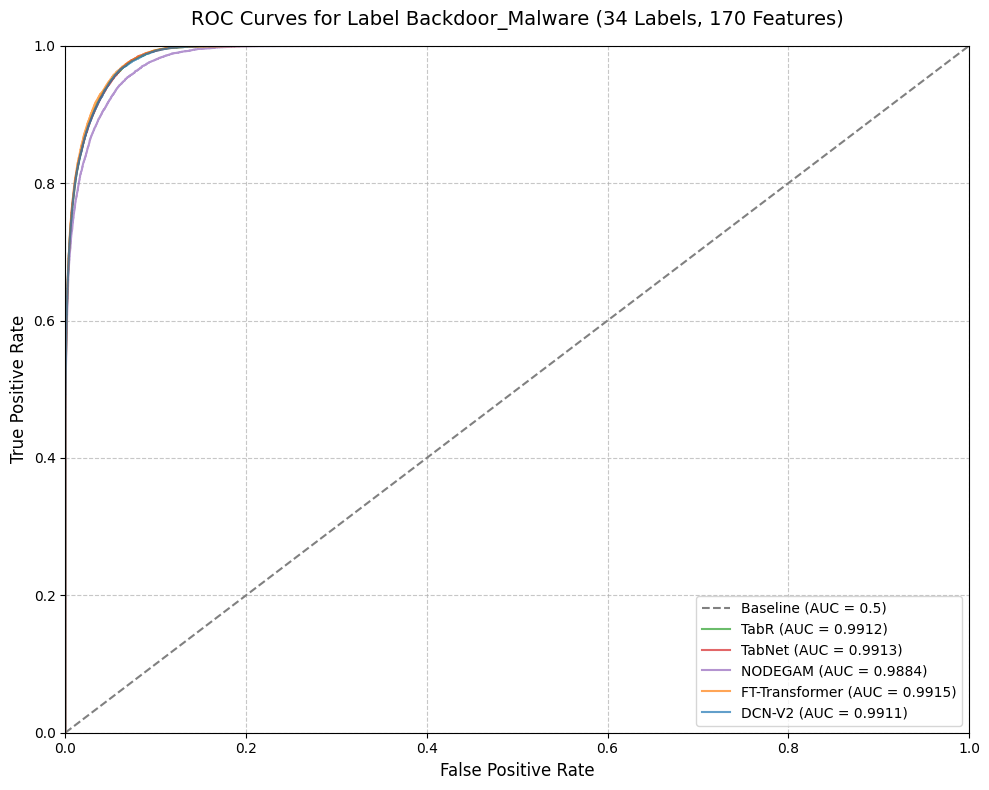

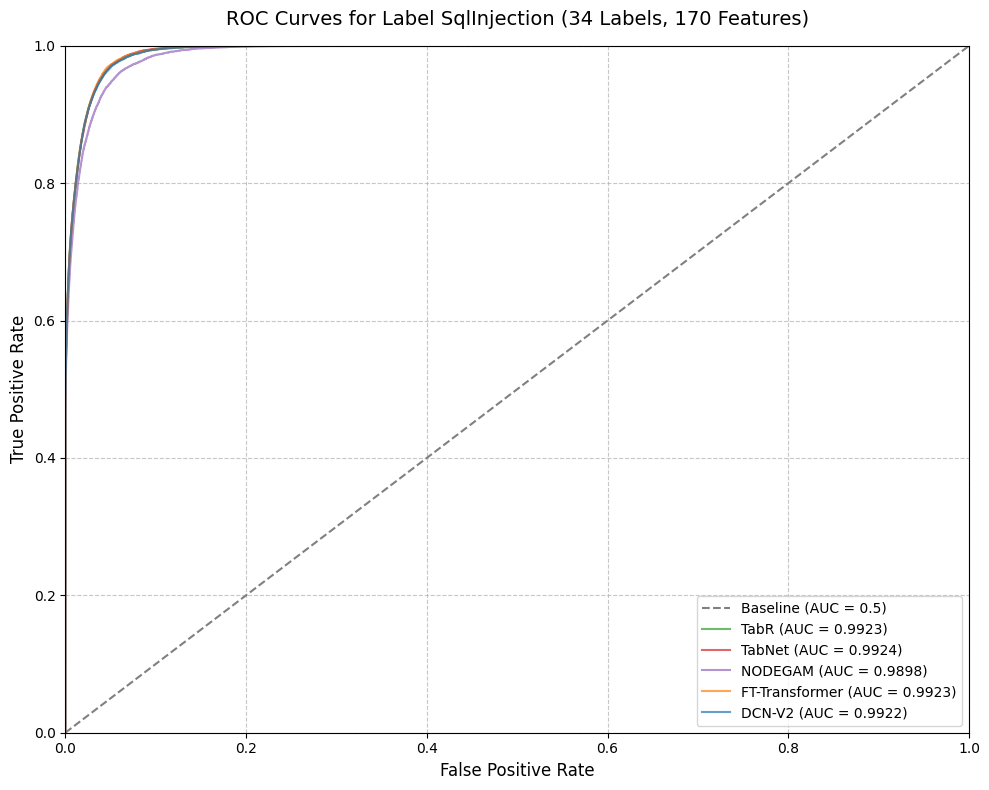

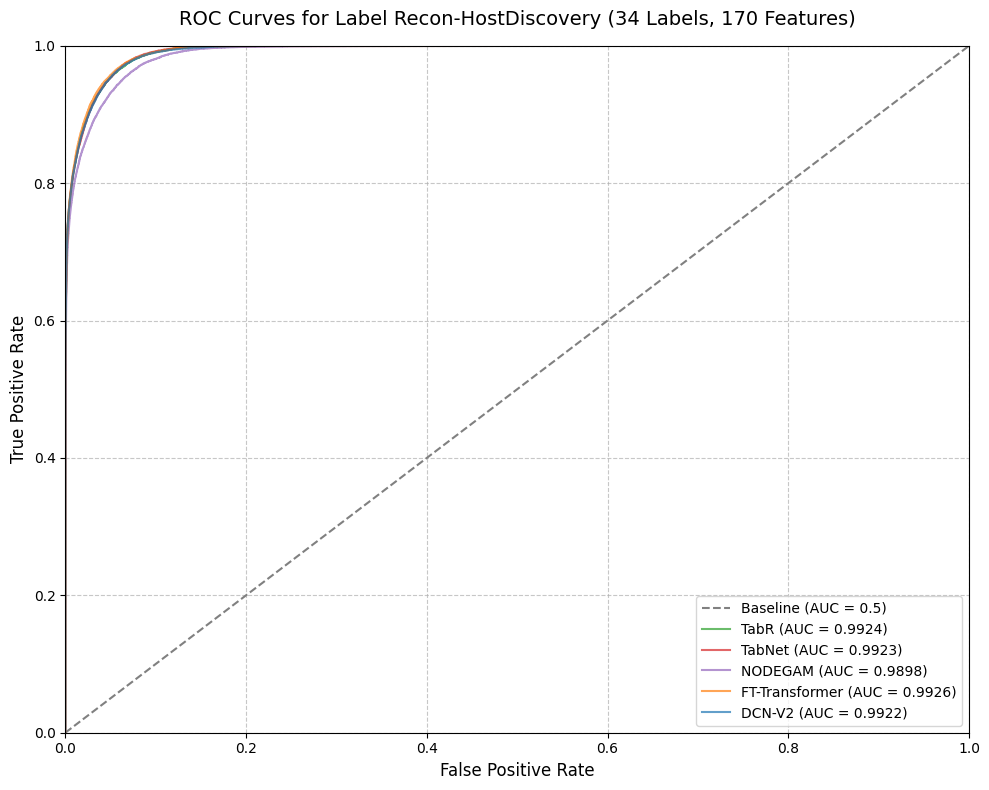

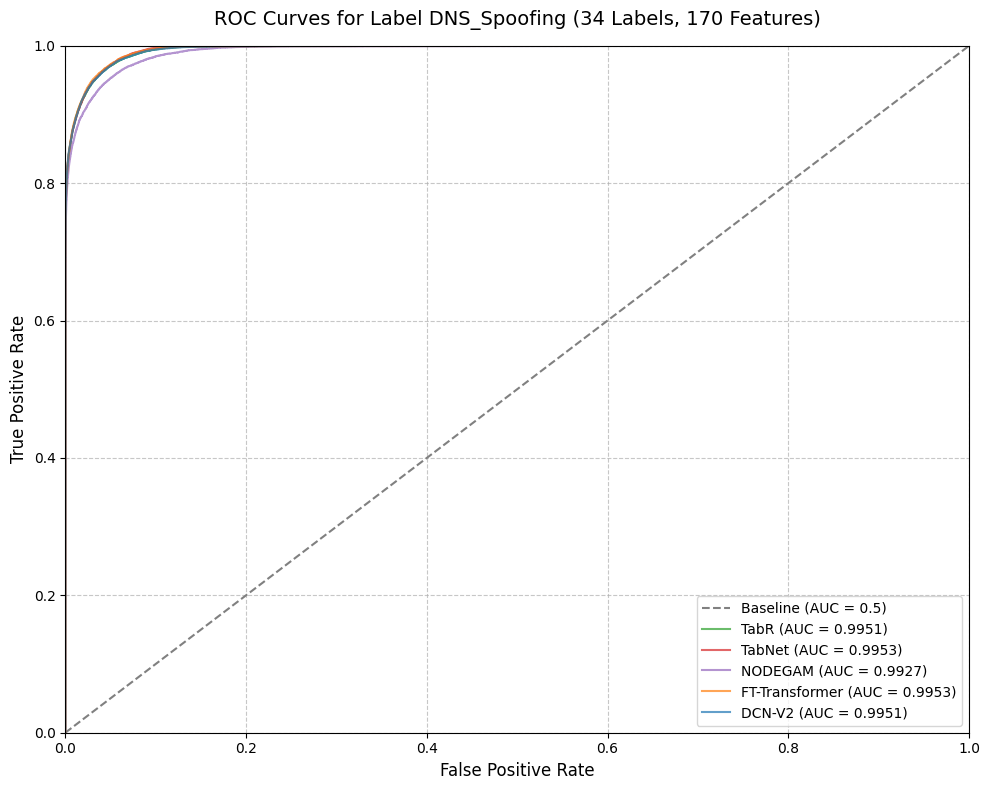

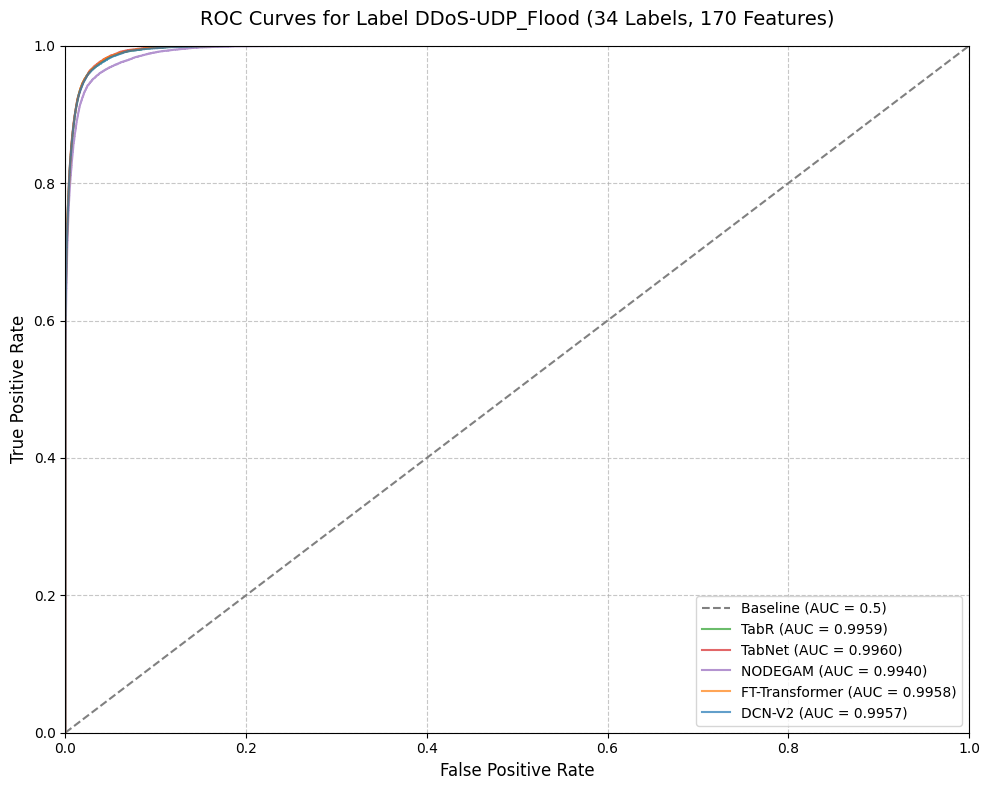

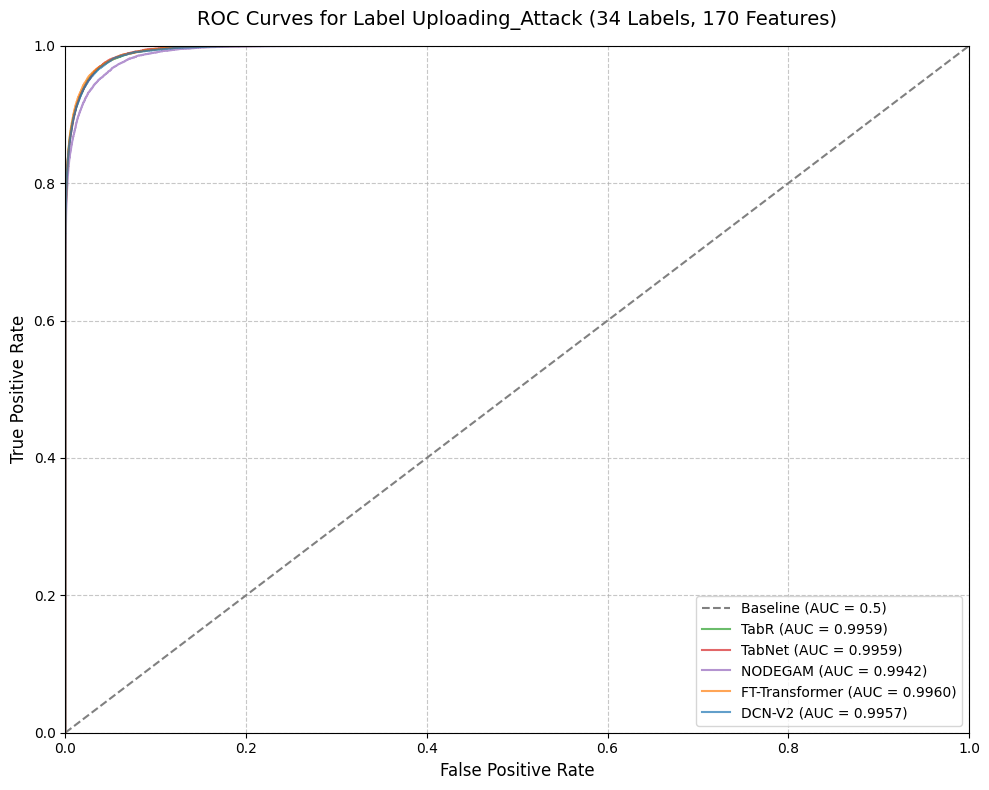

✅ Hoàn tất vẽ ROC cho 6 nhãn có AUC thấp nhất!


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import os
from tqdm import tqdm

# Danh sách mô hình và thư mục kết quả
models = {
    'TabR': '/kaggle/input/ketqua34nhan/tabr-34nhan-cuoi/results',
    'TabNet': '/kaggle/input/ketqua34nhan/tabnet-34nhan-cuoi/results',
    'NODEGAM': '/kaggle/input/ketqua34nhan/node-gam-34/results',
    'FT-Transformer': '/kaggle/input/ketqua34nhan/fttran-34nhan/results',
    'DCN-V2': '/kaggle/input/ketqua34nhan/dcnv2-34nhan-cuoi/results'
}

# Tên file dữ liệu test_probs và test_labels
file_suffixes = {
    'TabR': '34labels_170features_tabr',
    'TabNet': '34labels_170features_tabnet',
    'NODEGAM': '34labels_170features_nodegam',
    'FT-Transformer': '34labels_170features_fttransformer_pure',
    'DCN-V2': '34labels_170features_dcnv2'
}

# Màu sắc và kiểu đường cho từng mô hình (đồng bộ với sơ đồ)
styles = {
    'TabR': {'color': '#2ca02c', 'linestyle': '-', 'label': 'TabR', 'linewidth': 1.5},  # Green
    'TabNet': {'color': '#d62728', 'linestyle': '-', 'label': 'TabNet', 'linewidth': 1.5},  # Red
    'NODEGAM': {'color': '#9467bd', 'linestyle': '-', 'label': 'NODEGAM', 'linewidth': 1.5},  # Purple
    'FT-Transformer': {'color': '#ff7f0e', 'linestyle': '-', 'label': 'FT-Transformer', 'linewidth': 1.5},  # Orange
    'DCN-V2': {'color': '#1f77b4', 'linestyle': '-', 'label': 'DCN-V2', 'linewidth': 1.5}  # Blue
}

# Ánh xạ nhãn cho bài toán 34 nhãn
label_map = {
    0: 'DDoS-ICMP_Flood', 1: 'DDoS-UDP_Flood', 2: 'DDoS-TCP_Flood', 3: 'DDoS-PSHACK_Flood',
    4: 'DDoS-SYN_Flood', 5: 'DDoS-RSTFINFlood', 6: 'DDoS-SynonymousIP_Flood', 7: 'DDoS-ICMP_Fragmentation',
    8: 'DDoS-UDP_Fragmentation', 9: 'DDoS-ACK_Fragmentation', 10: 'DDoS-HTTP_Flood', 11: 'DDoS-SlowLoris',
    12: 'DoS-UDP_Flood', 13: 'DoS-TCP_Flood', 14: 'DoS-SYN_Flood', 15: 'DoS-HTTP_Flood',
    16: 'Recon-HostDiscovery', 17: 'Recon-OSScan', 18: 'Recon-PortScan', 19: 'Recon-PingSweep',
    20: 'VulnerabilityScan', 21: 'MITM-ArpSpoofing', 22: 'DNS_Spoofing', 23: 'DictionaryBruteForce',
    24: 'BrowserHijacking', 25: 'XSS', 26: 'Uploading_Attack', 27: 'SqlInjection', 28: 'CommandInjection',
    29: 'Backdoor_Malware', 30: 'Mirai-greeth_flood', 31: 'Mirai-udpplain', 32: 'Mirai-greip_flood',
    33: 'BenignTraffic'
}

# Thư mục lưu kết quả
output_dir = "ROC_34Labels"
os.makedirs(output_dir, exist_ok=True)
tqdm.write(f"📁 Đảm bảo thư mục lưu kết quả: {output_dir}")

# Tải dữ liệu và kiểm tra
data = {}
for model_name, results_dir in models.items():
    try:
        test_probs = np.load(f"{results_dir}/test_probs_{file_suffixes[model_name]}.npy")
        test_labels = np.load(f"{results_dir}/test_labels_{file_suffixes[model_name]}.npy")
        
        # Kiểm tra dữ liệu
        if test_probs.shape[1] != 34 or np.any(test_probs < 0) or np.any(test_probs > 1):
            tqdm.write(f"⚠️ Dữ liệu test_probs của {model_name} không hợp lệ: shape {test_probs.shape}")
            continue
        if test_probs.shape[0] != test_labels.shape[0]:
            tqdm.write(f"⚠️ Số mẫu không khớp giữa test_probs và test_labels cho {model_name}")
            continue
        
        data[model_name] = {'test_probs': test_probs, 'test_labels': test_labels}
        tqdm.write(f"✅ Đã tải dữ liệu cho {model_name}")
    except Exception as e:
        tqdm.write(f"❌ Lỗi khi tải dữ liệu cho {model_name}: {str(e)}")
        continue

# Kiểm tra xem có đủ mô hình không
if len(data) < 5:
    tqdm.write(f"⚠️ Chỉ tải được dữ liệu cho {len(data)} mô hình. Cần 5 mô hình để tiếp tục.")
    raise ValueError("Không đủ dữ liệu mô hình")

# Tính AUC cho tất cả nhãn và chọn 6 nhãn có AUC thấp nhất
auc_scores = {label: [] for label in range(34)}
for model_name in data:
    test_probs = data[model_name]['test_probs']
    test_labels = data[model_name]['test_labels']
    for label in range(34):
        auc = roc_auc_score(test_labels == label, test_probs[:, label])
        auc_scores[label].append(auc)
        tqdm.write(f"📈 {model_name} - ROC-AUC Label {label_map[label]}: {auc:.4f}")

# Tính AUC trung bình và chọn 6 nhãn thấp nhất
mean_auc = {label: np.mean(scores) for label, scores in auc_scores.items()}
lowest_auc_labels = sorted(mean_auc, key=mean_auc.get)[:6]
tqdm.write(f"📌 6 nhãn có AUC thấp nhất: {[label_map[label] for label in lowest_auc_labels]}")

# Vẽ ROC cho 6 nhãn có AUC thấp nhất
for label in lowest_auc_labels:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Đường baseline
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline (AUC = 0.5)', linewidth=1.5)
    
    # Tính và vẽ ROC cho từng mô hình
    for model_name in data:
        test_probs = data[model_name]['test_probs']
        test_labels = data[model_name]['test_labels']
        
        fpr, tpr, _ = roc_curve(test_labels == label, test_probs[:, label])
        roc_auc = roc_auc_score(test_labels == label, test_probs[:, label])
        ax.plot(fpr, tpr, 
                color=styles[model_name]['color'], 
                linestyle=styles[model_name]['linestyle'], 
                linewidth=styles[model_name]['linewidth'], 
                alpha=0.7, 
                label=f"{styles[model_name]['label']} (AUC = {roc_auc:.4f})")
    
    # Cài đặt cho biểu đồ
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.set_title(f"ROC Curves for Label {label_map[label]} (34 Labels, 170 Features)", fontsize=14, pad=15)
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    
    # Lưu biểu đồ
    plt.tight_layout()
    plt.savefig(f"{output_dir}/roc_label_{label_map[label]}_combined_5models.png", bbox_inches="tight", dpi=300)
    plt.show()  # Hiển thị biểu đồ

tqdm.write("✅ Hoàn tất vẽ ROC cho 6 nhãn có AUC thấp nhất!")